In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import xarray as xr

from matplotlib import ticker

def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

import covid19

In [3]:
lut_path = 'UID_ISO_FIPS_LookUp_Table.csv'
# lut_path = covid19.data.download('LUT', repo='world')
lut_path

'UID_ISO_FIPS_LookUp_Table.csv'

In [4]:
deaths_path = 'time_series_covid19_deaths_global.csv'
deaths_path = covid19.data.download('deaths', repo='world')
confirmed_path = 'time_series_covid19_confirmed_global.csv'
confirmed_path = covid19.data.download('confirmed', repo='world')
deaths_path, confirmed_path

('time_series_covid19_deaths_global.csv',
 'time_series_covid19_confirmed_global.csv')

In [5]:
world = covid19.data.read_jhu_global(deaths_path, lut_path=lut_path)
world['confirmed'] = covid19.data.read_jhu_global(confirmed_path)['deaths']

europe = world.sel(location=['Italy', 'United Kingdom', 'France', 'Spain', 'Belgium', 'Netherlands', 'Sweden', 'Ireland', 'Switzerland', 'Portugal', 'Germany']).sum('location')
europe['daily_deaths'] = europe['deaths'].diff('time')
print(europe)

world['daily_deaths'] = world['deaths'].diff('time')
world['daily_confirmed'] = world['confirmed'].diff('time')
world['mortality'] = world['deaths'] / world.population * 1_000_000
world['prevalence'] = world['confirmed'] / world.population * 1_000_000
world['daily_prevalence'] = world['daily_confirmed'] / world.population * 1_000_000
world['daily_mortality'] = world['daily_deaths'] / world.population * 1_000_000
world['daily_deaths7'] = world['daily_deaths'].rolling({'time': 7}).mean()
world['daily_mortality7'] = world['daily_deaths7'] / world.population * 1_000_000
world['daily_mortality14'] = world['daily_deaths'].rolling({'time': 14}).mean() / world.population * 1_000_000
world['daily_confirmed7'] = world['daily_confirmed'].rolling({'time': 7}).mean()
world['daily_prevalence7'] = world['daily_confirmed7'] / world.population * 1_000_000
world = world.drop(['lat', 'lon'])
world

<xarray.Dataset>
Dimensions:       (time: 324)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-12-10
Data variables:
    deaths        (time) int64 0 0 0 0 0 ... 287853 290082 293216 295821 298867
    confirmed     (time) int64 0 0 2 3 3 ... 10866671 10971069 11075451 11195520
    daily_deaths  (time) float64 nan 0.0 0.0 ... 3.134e+03 2.605e+03 3.046e+03


<xarray.Dataset>
Dimensions:            (location: 271, time: 324)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-12-10
    country            (location) <U32 'Afghanistan' 'Albania' ... 'Zimbabwe'
  * location           (location) <U46 'Afghanistan' 'Albania' ... 'Zimbabwe'
    state_region       (location) <U46 'Afghanistan / ' ... 'Zimbabwe / '
    population         (location) float64 3.893e+07 2.878e+06 ... 1.486e+07
Data variables:
    deaths             (time, location) int64 0 0 0 0 0 0 ... 35 910 606 364 305
    confirmed          (time, location) int64 0 0 0 0 ... 2081 18091 11081
    daily_deaths       (time, location) float64 nan nan nan nan ... 0.0 0.0 1.0
    daily_confirmed    (time, location) float64 nan nan nan ... 2.0 29.0 74.0
    mortality          (time, location) float64 0.0 0.0 0.0 ... 20.32 19.8 20.52
    prevalence         (time, location) float64 0.0 0.0 0.0 ... 984.1 745.5
    daily_prevalence   (time, location) float64 nan nan nan ... 1.577 4.979
    daily_mortality    (time, location) float64 nan nan nan ... 0.0 0.0 0.06728
    daily_deaths7      (time, location) float64 nan nan nan ... -2.571 1.0 3.571
    daily_mortality7   (time, location) float64 nan nan nan ... 0.0544 0.2403
    daily_mortality14  (time, location) float64 nan nan nan ... 0.0272 0.149
    daily_confirmed7   (time, location) float64 nan nan nan ... 51.57 93.86
    daily_prevalence7  (time, location) float64 nan nan nan ... 2.805 6.315

In [6]:
world_latest = world.isel(time=-1)
world_latest = world_latest.sortby(-world_latest['daily_mortality7'])
world_latest.sortby(-world_latest['mortality']).to_dataframe().reset_index().head(18)[['country', 'mortality', 'daily_mortality7']]


country    mortality  daily_mortality7
0                  Belgium  1526.538929          8.123035
1               San Marino  1443.809299         12.628070
2                     Peru  1106.974720          1.832732
3                    Italy  1035.794022         10.840370
4                    Spain  1012.602283          3.990424
5                  Andorra  1009.512716          1.848924
6          North Macedonia   984.457948         13.988258
7   Bosnia and Herzegovina   975.062599         16.851214
8                 Slovenia   937.500601         24.531827
9           United Kingdom   929.234250          6.247869
10              Montenegro   901.184915         11.372854
11               Argentina   894.574730          3.559119
12                      US   886.709855          6.857845
13                  Mexico   878.973243          4.642578
14                  France   866.875372          6.112740
15                 Czechia   861.519797          7.803863
16                  Brazil   845.716503          3.021004
17                   Chile   825.163609          1.905638

In [7]:
world_latest.to_dataframe().reset_index().head(60)

location       time                 country  \
0                 Slovenia 2020-12-10                Slovenia   
1                 Bulgaria 2020-12-10                Bulgaria   
2   Bosnia and Herzegovina 2020-12-10  Bosnia and Herzegovina   
3                  Hungary 2020-12-10                 Hungary   
4                  Croatia 2020-12-10                 Croatia   
5          North Macedonia 2020-12-10         North Macedonia   
6               San Marino 2020-12-10              San Marino   
7               Montenegro 2020-12-10              Montenegro   
8                    Italy 2020-12-10                   Italy   
9                   Kosovo 2020-12-10                  Kosovo   
10             Switzerland 2020-12-10             Switzerland   
11                  Poland 2020-12-10                  Poland   
12              Luxembourg 2020-12-10              Luxembourg   
13                 Austria 2020-12-10                 Austria   
14                 Georgia 2020-12-10                 Georgia   
15                  Greece 2020-12-10                  Greece   
16               Lithuania 2020-12-10               Lithuania   
17                 Belgium 2020-12-10                 Belgium   
18                 Romania 2020-12-10                 Romania   
19                 Armenia 2020-12-10                 Armenia   
20                 Czechia 2020-12-10                 Czechia   
21                Portugal 2020-12-10                Portugal   
22           Liechtenstein 2020-12-10           Liechtenstein   
23                      US 2020-12-10                      US   
24                  Belize 2020-12-10                  Belize   
25                  Serbia 2020-12-10                  Serbia   
26          United Kingdom 2020-12-10          United Kingdom   
27                  France 2020-12-10                  France   
28                 Albania 2020-12-10                 Albania   
29                  Latvia 2020-12-10                  Latvia   
30                 Ukraine 2020-12-10                 Ukraine   
31                   Malta 2020-12-10                   Malta   
32                 Germany 2020-12-10                 Germany   
33                  Sweden 2020-12-10                  Sweden   
34                 Moldova 2020-12-10                 Moldova   
35                  Panama 2020-12-10                  Panama   
36                 Tunisia 2020-12-10                 Tunisia   
37                  Jordan 2020-12-10                  Jordan   
38                  Mexico 2020-12-10                  Mexico   
39                Slovakia 2020-12-10                Slovakia   
40                   Spain 2020-12-10                   Spain   
41              Azerbaijan 2020-12-10              Azerbaijan   
42                    Iran 2020-12-10                    Iran   
43      West Bank and Gaza 2020-12-10      West Bank and Gaza   
44               Argentina 2020-12-10               Argentina   
45                  Russia 2020-12-10                  Russia   
46              Costa Rica 2020-12-10              Costa Rica   
47                Colombia 2020-12-10                Colombia   
48                  Brazil 2020-12-10                  Brazil   
49             Netherlands 2020-12-10             Netherlands   
50                  Turkey 2020-12-10                  Turkey   
51                Paraguay 2020-12-10                Paraguay   
52            South Africa 2020-12-10            South Africa   
53                 Lebanon 2020-12-10                 Lebanon   
54                 Estonia 2020-12-10                 Estonia   
55                 Ecuador 2020-12-10                 Ecuador   
56                   Chile 2020-12-10                   Chile   
57                  Cyprus 2020-12-10                  Cyprus   
58                 Andorra 2020-12-10                 Andorra   
59                    Peru 2020-12-10                    Peru   

                 state_region   population  deaths  

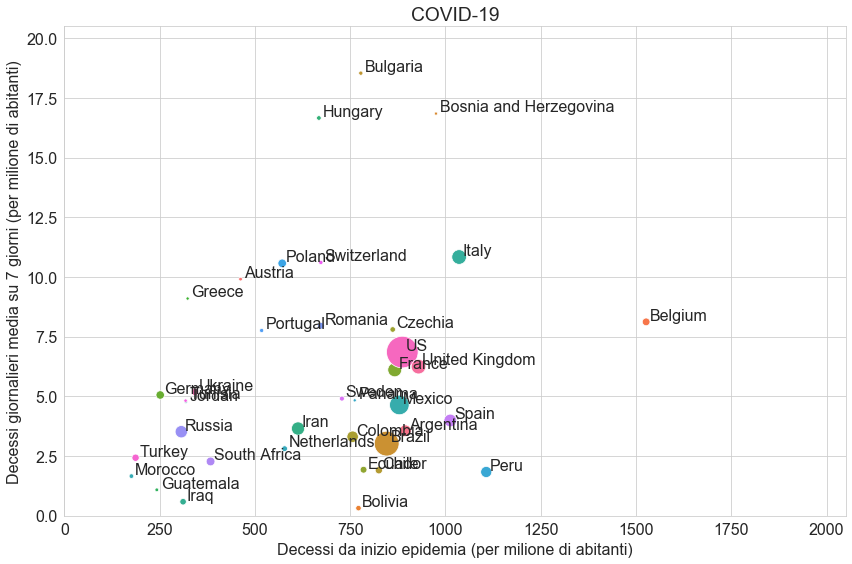

In [8]:
# import seaborn as sns
# sns.set()
world_hit = world.sel(location=(((world['daily_mortality7'].isel(time=-1) > 1.) | (world['mortality'].isel(time=-1) > 200)) & (world['deaths'] > 3000)).any('time')).to_dataframe().reset_index()
#ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 20.5), xlim=(0, 2050))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    #if record['daily_mortality7'] > 19:
    #    continue
    ax.annotate(record['location'], (record['mortality'] + 10, record['daily_mortality7'] + .08))
_ = ax.set(title='COVID-19', xlabel='Decessi da inizio epidemia (per milione di abitanti)', ylabel='Decessi giornalieri media su 7 giorni (per milione di abitanti)')

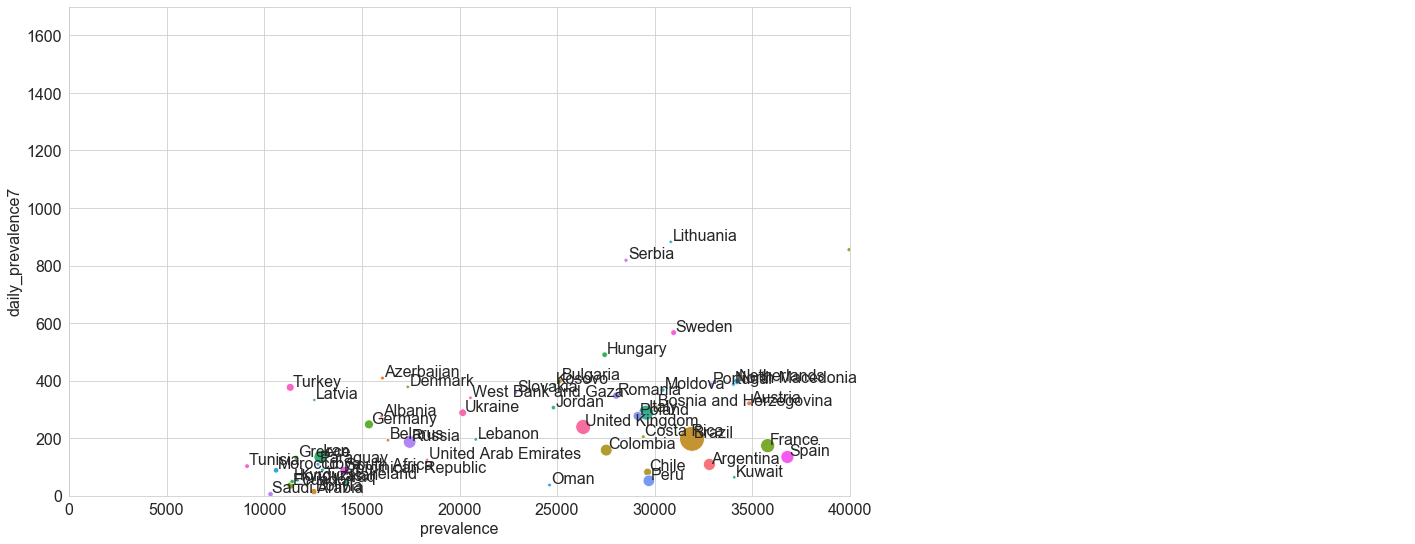

In [9]:
import seaborn as sns
# sns.set()
world_hit = world.sel(location=(((world['prevalence'].isel(time=-1) > 10000) | (world['daily_prevalence7'].isel(time=-1) > 100.)) & (world['deaths'] > 300.)).any('time')).to_dataframe().reset_index()
# ax = sns.scatterplot(y="daily_mortality7", x="daily_prevalence7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(y="daily_prevalence7", x="prevalence", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 1700), xlim=(0, 40000))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_prevalence7'] > 1700 or record['daily_mortality7'] > 40000:
        continue
    ax.annotate(record['location'], (record['prevalence'] + 100, record['daily_prevalence7'] + 5))

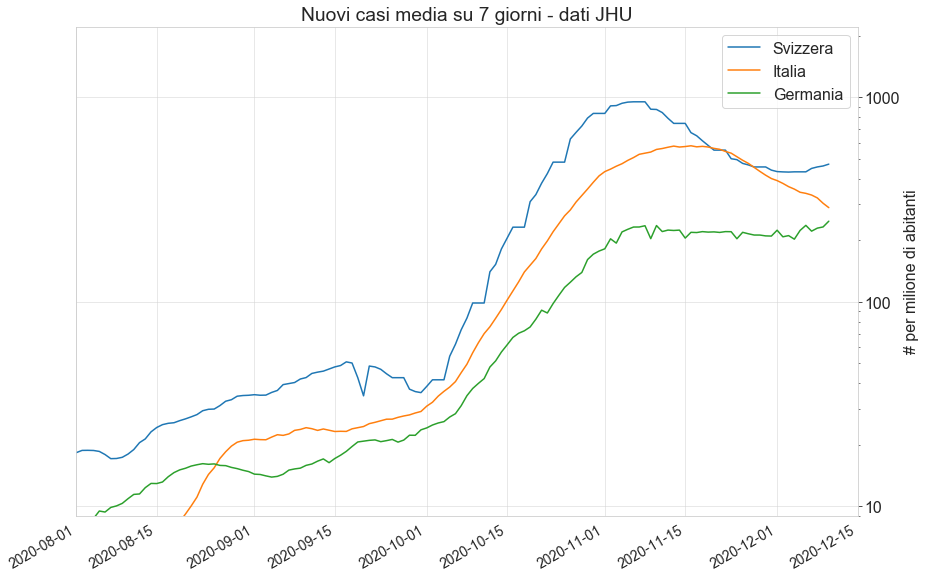

In [10]:
_, ax = covid19.plot.subplots()
#world.sel(location='Argentina')['daily_prevalence7'] / 1).plot(label='Argentina')
#world.sel(location='Israel')['daily_prevalence7'].plot(label='Israele')
#world.sel(location='Spain')['daily_prevalence7'].plot(label='Spagna')
#world.sel(location='France')['daily_prevalence7'].plot(label='Francia')
#world.sel(location='India')['daily_prevalence7'].plot(label='Francia')
#world.sel(location='US')['daily_prevalence7'].plot(label='US')
#world.sel(location='Netherlands')['daily_prevalence7'].plot(label='Olanda')
#world.sel(location='Belgium')['daily_prevalence7'].plot(label='Belgio')
#world.sel(location='Sweden')['daily_prevalence7'].plot(label='Svezia')
#world.sel(location='United Kingdom')['daily_prevalence7'].plot(label='UK')
world.sel(location='Switzerland')['daily_prevalence7'].plot(label='Svizzera')
world.sel(location='Italy')['daily_prevalence7'] .plot(label='Italia')
world.sel(location='Germany')['daily_prevalence7'].plot(label='Germania')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
#world.sel(location='Vietnam')['daily_prevalence7'].plot(label='Vietnam')
#world.sel(location='Japan')['daily_prevalence7'].plot(label='Giappone')
#world.sel(location='New Zealand')['daily_prevalence7'].plot(label='Nuova Zelanda')
plt.legend(loc='upper right')
plt.ylim(10 * 0.9, 2000 / 0.9)
plt.xlim(np.datetime64('2020-08-01'), np.datetime64('2020-12-15'))
plt.yscale('log')
plt.ylabel('# per milione di abitanti')
plt.xlabel('')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = plt.title("Nuovi casi media su 7 giorni - dati JHU")

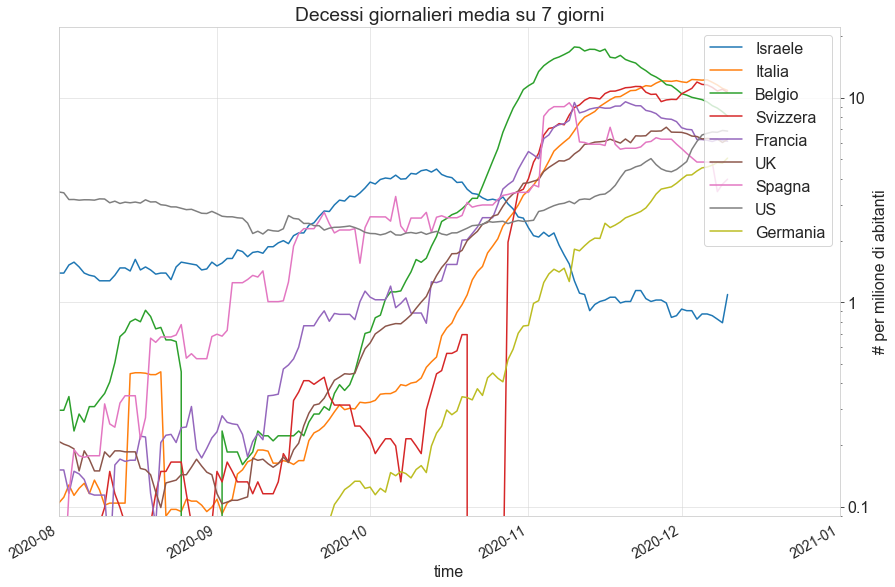

In [11]:
_, ax = covid19.plot.subplots()
#world.sel(location='Argentina')['daily_mortality7'].plot(label='Argentina')
#(world.sel(location='Brazil')['daily_mortality7'] / 1).plot(label='Argentina')
#(world.sel(location='Peru')['daily_mortality7'] / 1).plot(label='Argentina')
world.sel(location='Israel')['daily_mortality7'].plot(label='Israele')
world.sel(location='Italy')['daily_mortality7'].plot(label='Italia')
world.sel(location='Belgium')['daily_mortality7'].plot(label='Belgio')
world.sel(location='Switzerland')['daily_mortality7'].plot(label='Svizzera')
world.sel(location='France')['daily_mortality7'].plot(label='Francia')
world.sel(location='United Kingdom')['daily_mortality7'].plot(label='UK')
world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna')
world.sel(location='US')['daily_mortality7'].plot(label='US')
#world.sel(location='Netherlands')['daily_mortality7'].plot(label='Olanda')
#(world.sel(location='Austria')['daily_mortality7'] / 1).plot(label='Austria')
world.sel(location='Germany')['daily_mortality7'].plot(label='Germania')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
#world.sel(location='United Kingdom')['daily_mortality7'].plot(label='UK - decessi')
#world.sel(location='France')['daily_mortality7'].plot(label='Francia - decessi')
#world.sel(location='Austria')['daily_mortality7'].plot(label='Austria decessi giornalieri (media suà 7 giorni)')
#world.sel(location='Israel')['daily_mortality7'].plot(label='Israele - decessi')
#world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna - decessi')
#world.sel(location='Sweden')['daily_mortality7'].plot(label='Svezia')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Sweden')['daily_mortality7'].plot(label='Svezia - decessi')
plt.legend(loc='upper right')
plt.ylim(0.1 * 0.9, 20 / 0.9)
plt.xlim(np.datetime64('2020-08-01'), np.datetime64('2021-01-01'))
plt.yscale('log')
plt.ylabel('# per milione di abitanti')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = plt.title("Decessi giornalieri media su 7 giorni")

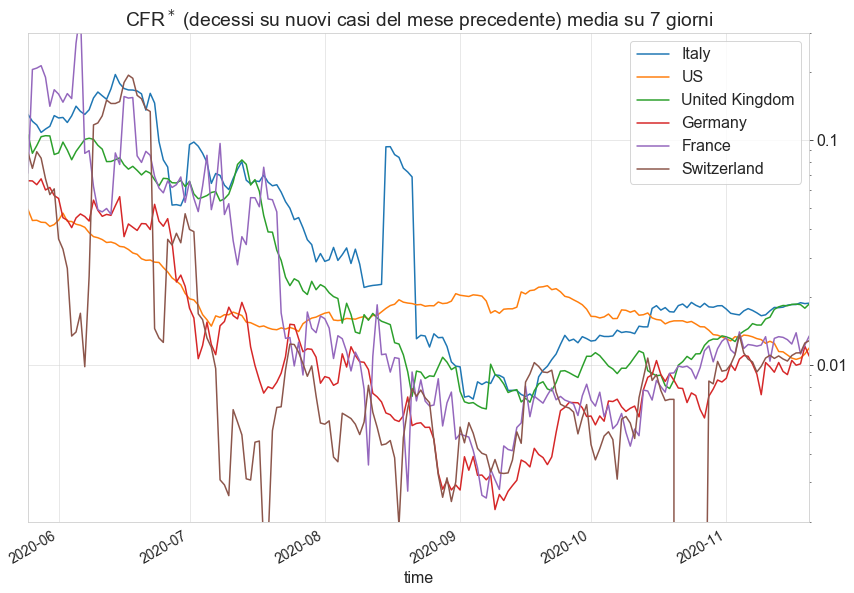

In [12]:
_, ax = covid19.plot.subplots()
#world.sel(location='Spain')['daily_confirmed7'].plot(label='Nuovi casi giornalieri (media su 7 giorni)')
#world.sel(location='Netherlands')['daily_prevalence7'].plot(label='Olanda')
#world.sel(location='Netherlands')['daily_mortality7'].plot(label='Olanda')
#world.sel(location='Croatia')['daily_prevalence7'].plot(label='Croatia')
#world.sel(location='Malta')['daily_prevalence7'].plot(label='Malta')
#world.sel(location='US')['daily_mortality7'].plot(label='US deaths')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud casi giornalieri (media su 7 giorni)')
#world.sel(location='Korea, South')['daily_mortality7'].plot(label='Corea del Sud')
#(world.sel(location='Spain')['daily_mortality7'] / 1).plot(label='Spagna')
#(world.sel(location='Israel')['daily_mortality7'] / 1).plot(label='Israele')
#(world.sel(location='US')['daily_mortality7'] / 1).plot(label='US')
#(world.sel(location='France')['daily_mortality7'] / 1).plot(label='Francia')
#(world.sel(location='United Kingdom')['daily_mortality7'] / 1).plot(label='UK')
#(world.sel(location='Belgium')['daily_mortality7'] / 1).plot(label='Belgio')
#(world.sel(location='Austria')['daily_mortality7'] / 1).plot(label='Austria')
delay = 10
for country in ['Italy', 'US', 'United Kingdom', 'Germany', 'France', 'Switzerland']:
    data = world.sel(location=country)
    #data['daily_mortality7'].plot(label=f'{country} - mortalità')
    #data['daily_prevalence7'].plot(label=f'{country}')
    #data['daily_prevalence7'].shift({'time': delay}).plot(label=f'{country}')
    (data['daily_mortality7'] / data['daily_prevalence7'].shift({'time': delay})).plot(label=f'{country}')
    
#world.sel(location='Italy')['daily_prevalence7'].plot(label='Italia - casi')
#world.sel(location='Germany')['daily_prevalence7'].plot(label='Germania - casi')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Germany')['daily_mortality7'].plot(label='Germania- decessi')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
#world.sel(location='United Kingdom')['daily_mortality7'].plot(label='UK - decessi')
#world.sel(location='France')['daily_mortality7'].plot(label='Francia - decessi')
#world.sel(location='Austria')['daily_mortality7'].plot(label='Austria decessi giornalieri (media suà 7 giorni)')
#world.sel(location='Israel')['daily_mortality7'].plot(label='Israele - decessi')
#world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna - decessi')
#world.sel(location='Germany')['daily_mortality7'].plot(label='Germania - decessi')
#world.sel(location='Italy')['daily_mortality7'].plot(label='Italia - decessi')
#world.sel(location='Sweden')['daily_mortality7'].plot(label='Svezia - decessi')
plt.legend(loc='upper right')
plt.ylim(0.002, 0.3)
plt.xlim(np.datetime64('2020-05-25'), np.datetime64('2020-11-20'))
plt.yscale('log')
#plt.ylabel('# per milione di abitanti')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
_ = plt.title("CFR$^*$ (decessi su nuovi casi del mese precedente) media su 7 giorni")

In [13]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

SHOWUNTIL = np.datetime64(world.time.values[-1], 's') + 10 * DAY

EXTENT = ('2020-02-20', SHOWUNTIL)
XLIM = tuple(map(np.datetime64, EXTENT))
XLIM_S = tuple([np.datetime64(d) + 10 * DAY for d in EXTENT])

In [75]:
PARAMS = {
    'China / Hubei': -36,
    'Iran': -2,
    'Korea, South': -1,
    'Italy': 0,
#     'EU': 0,
    'Spain': 5,
    'France': 11,
    'US': 12,
    'Japan': 13,
    'United Kingdom': 14,
    'Netherlands': 16,
    'Germany': 18,
    'Switzerland': 18,
    'Philippines': 18,
    'Indonesia': 19,
    'Belgium': 20,
    'Turkey': 21,
    'Brazil': 21,
    'Sweden': 23,
    'Algeria': 23,
    'Austria': 24,
    'Portugal': 24,
    'Ecuador': 24,
    'India': 29,
    'Canada / Ontario': 29,
    'Canada / Quebec': 30,
    'Mexico': 31,
    'Russia': 33,
}

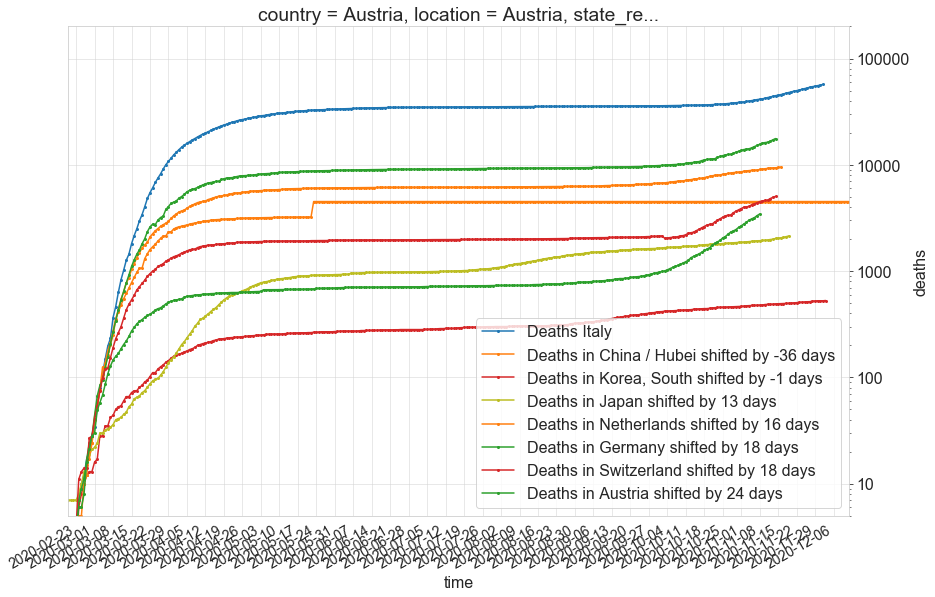

In [47]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 200000), 'xlim': XLIM}, figsize=(14, 9))
covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[1:])):
    if country not in ['Germany', 'Switzerland', 'Austria', 'Netherlands', 'Korea, South', 'Japan', 'China / Hubei']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color)
_ = ax.legend()

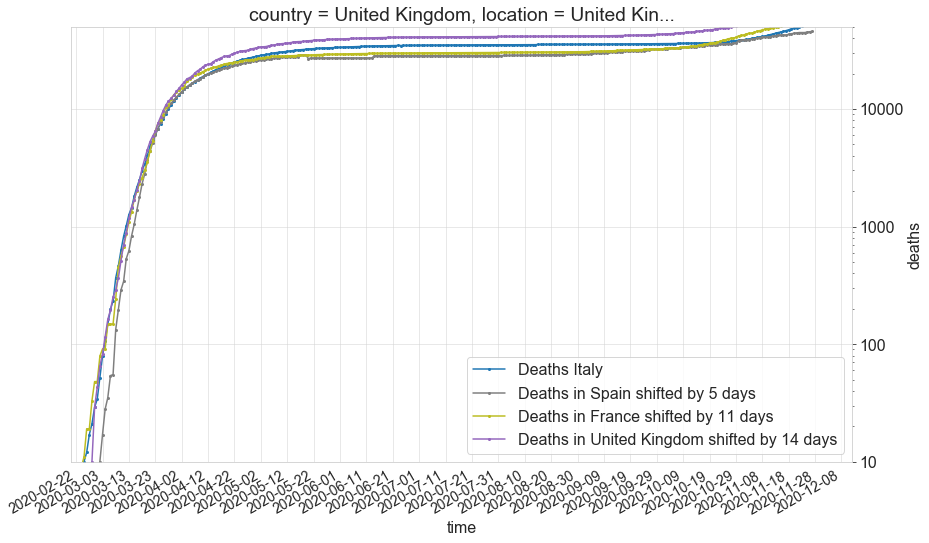

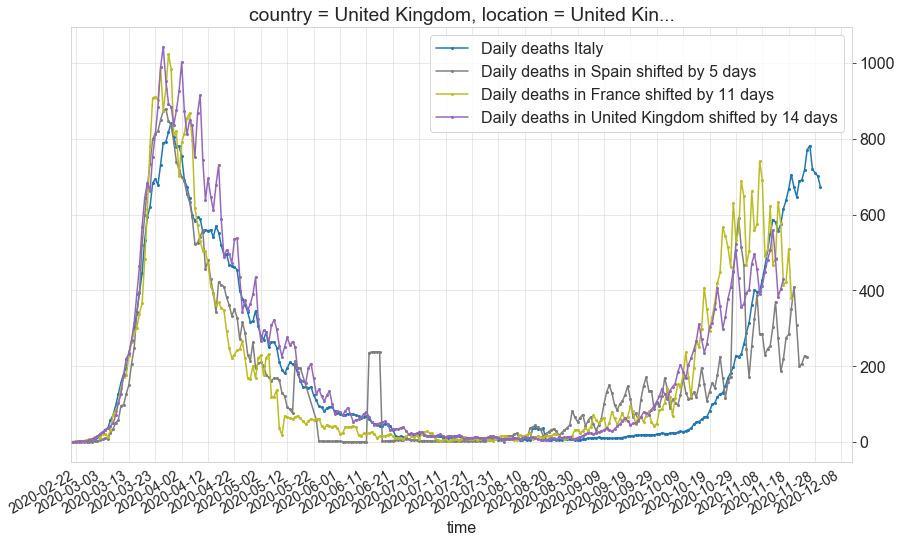

In [48]:
_, ax = covid19.plot.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 50000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = covid19.plot.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['France', 'United Kingdom', 'Spain']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

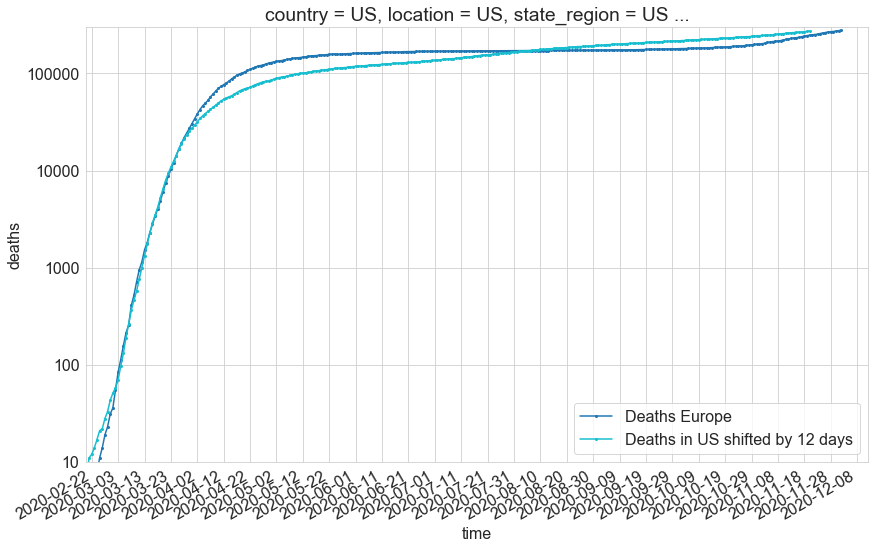

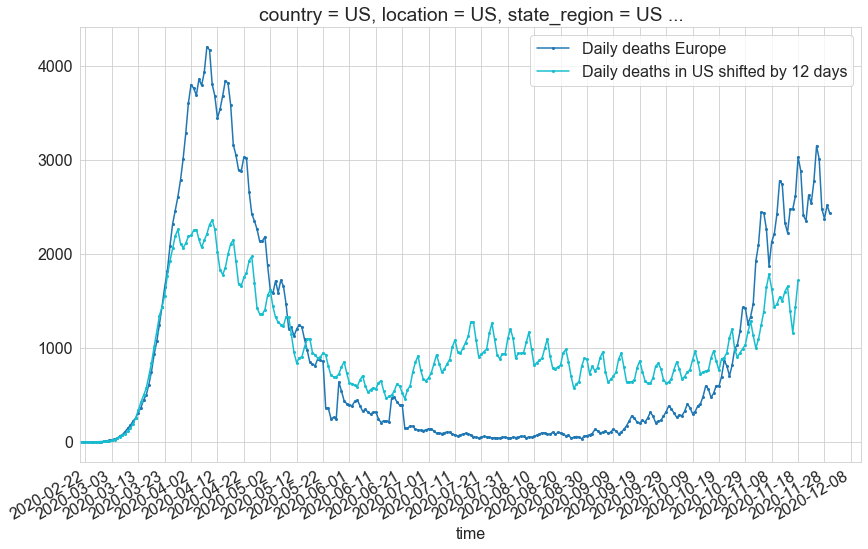

In [49]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 300000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = plt.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, europe['deaths'], label=f'Deaths Europe', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, europe['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Europe', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['US']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

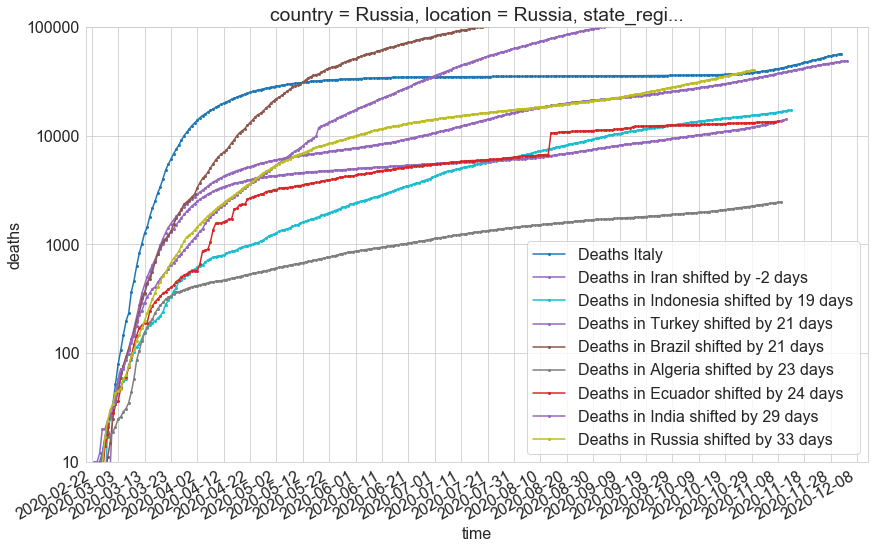

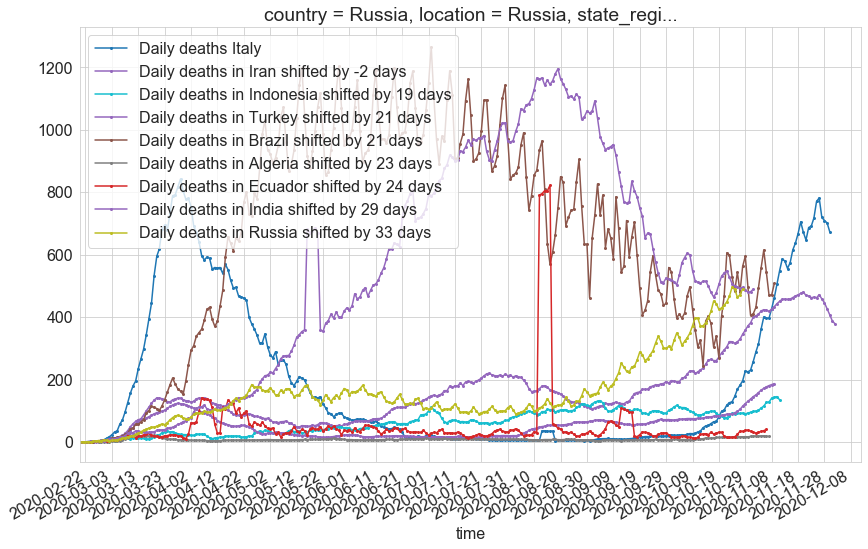

In [50]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 100000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = plt.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['Iran', 'Brazil', 'Turkey', 'India', 'Indonesia', 'Ecuador', 'Algeria', 'Russia']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

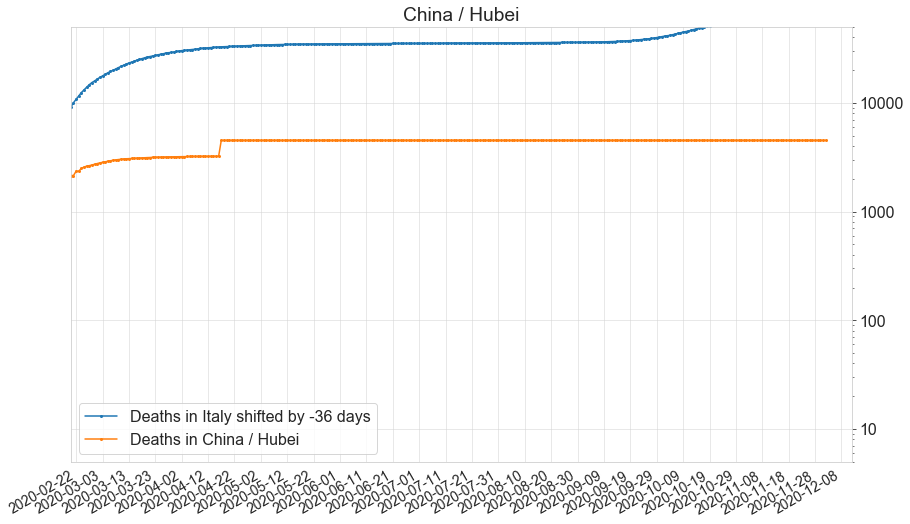

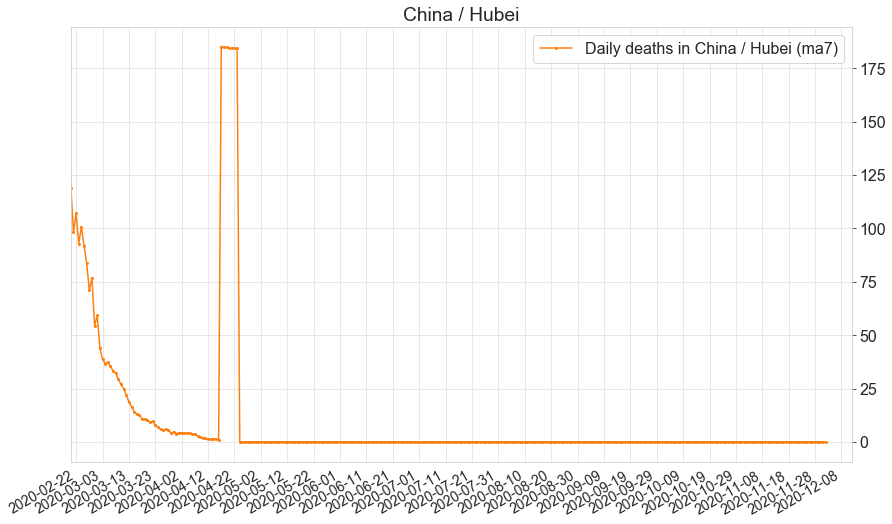

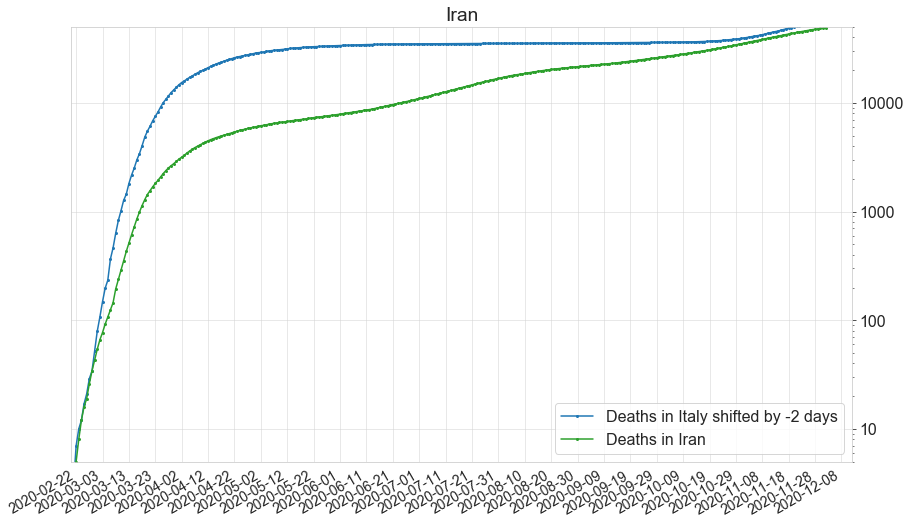

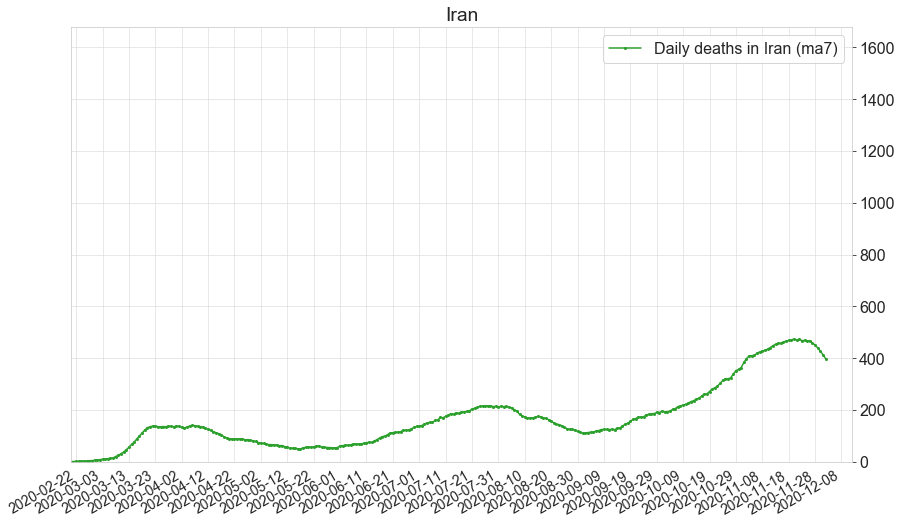

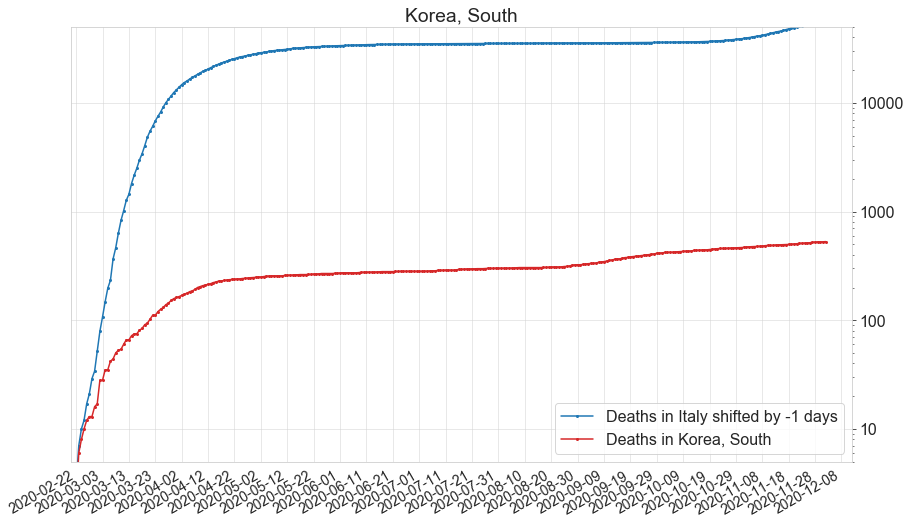

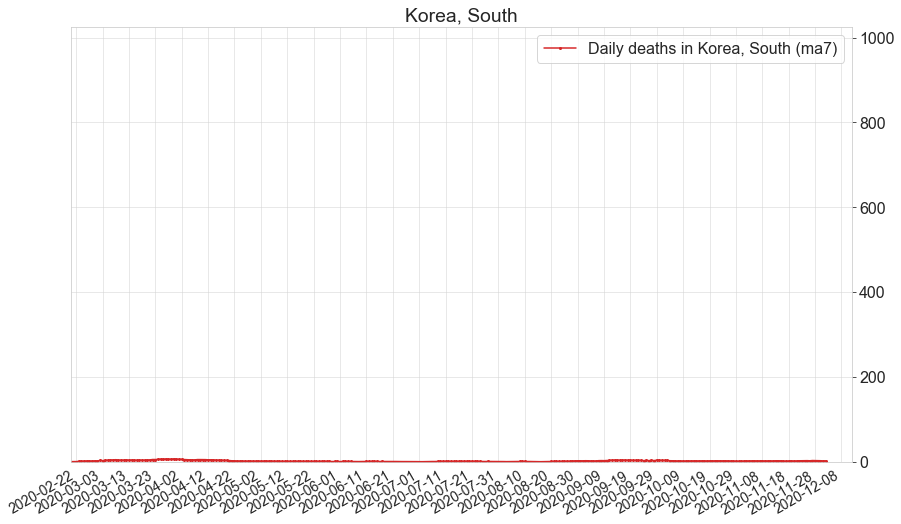

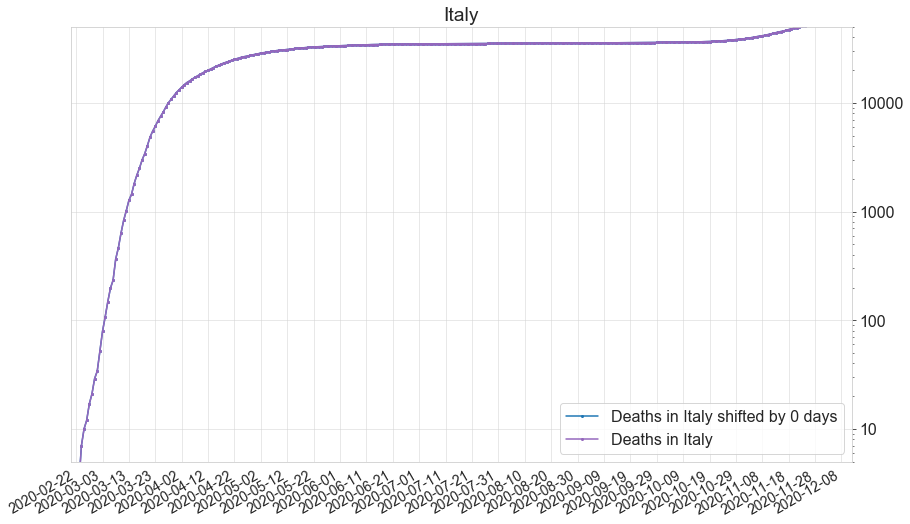

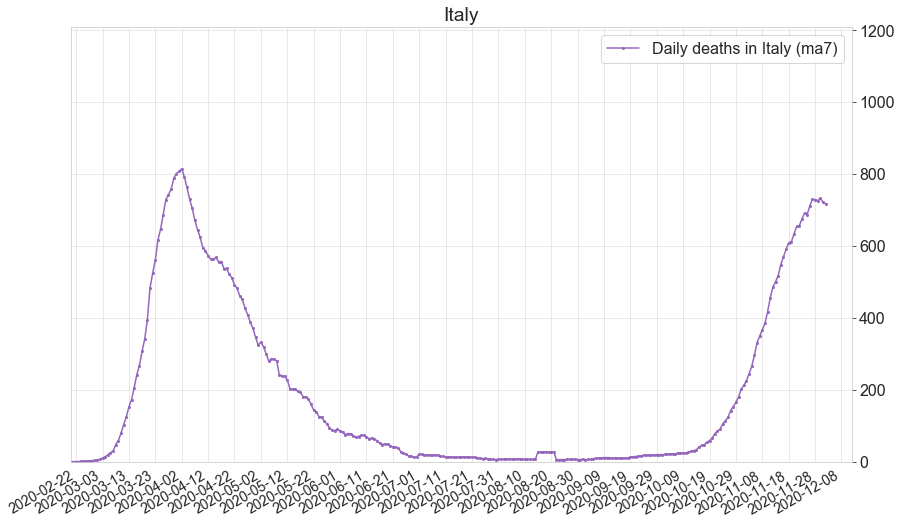

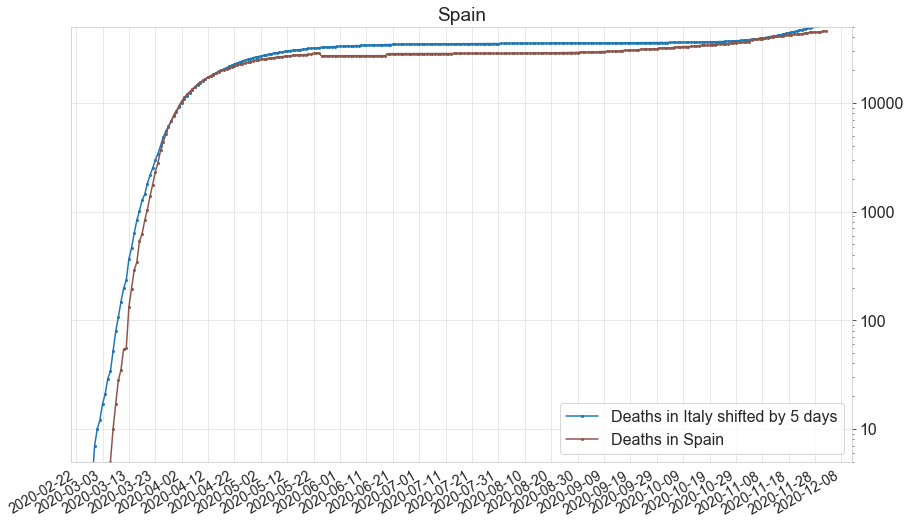

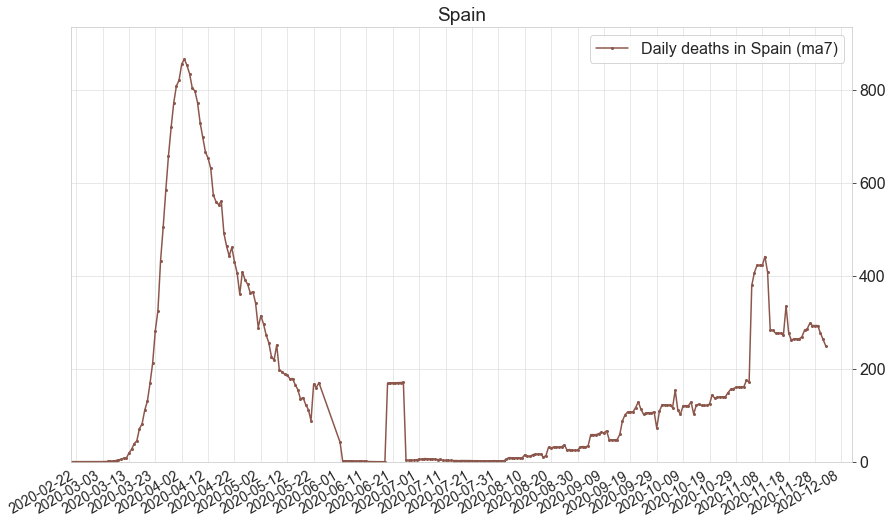

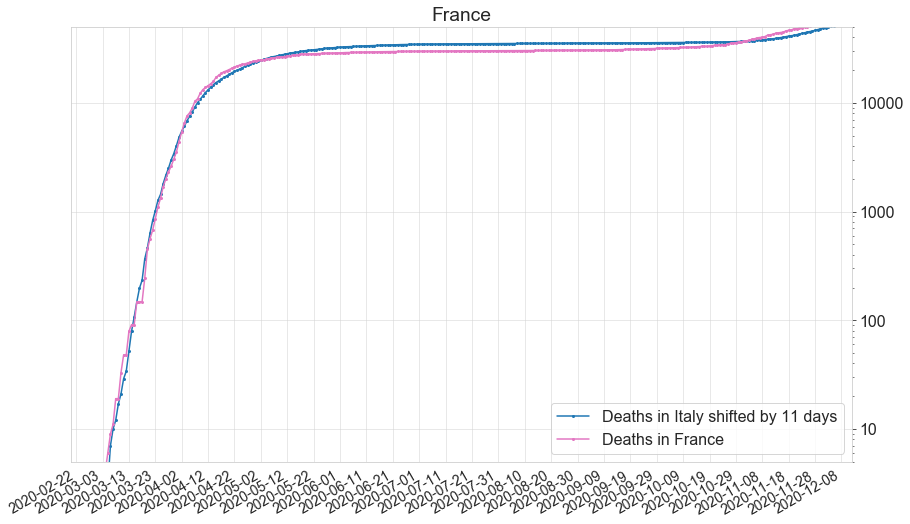

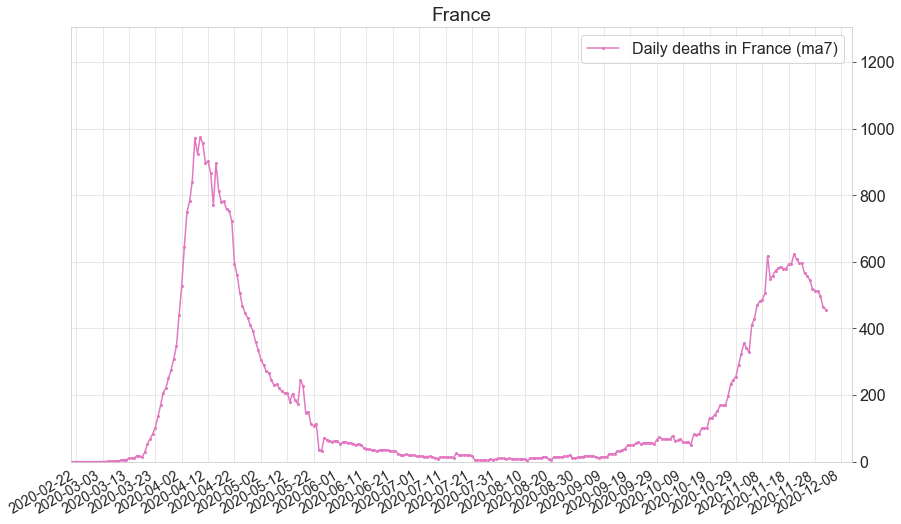

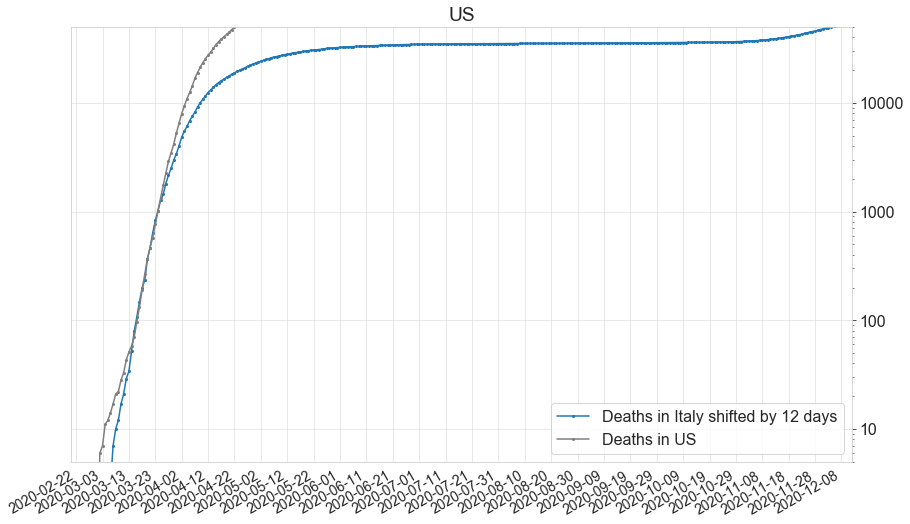

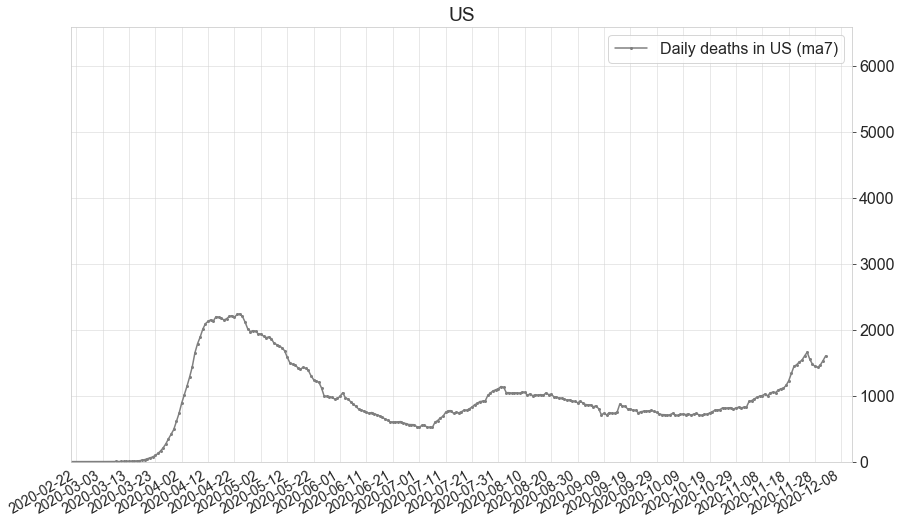

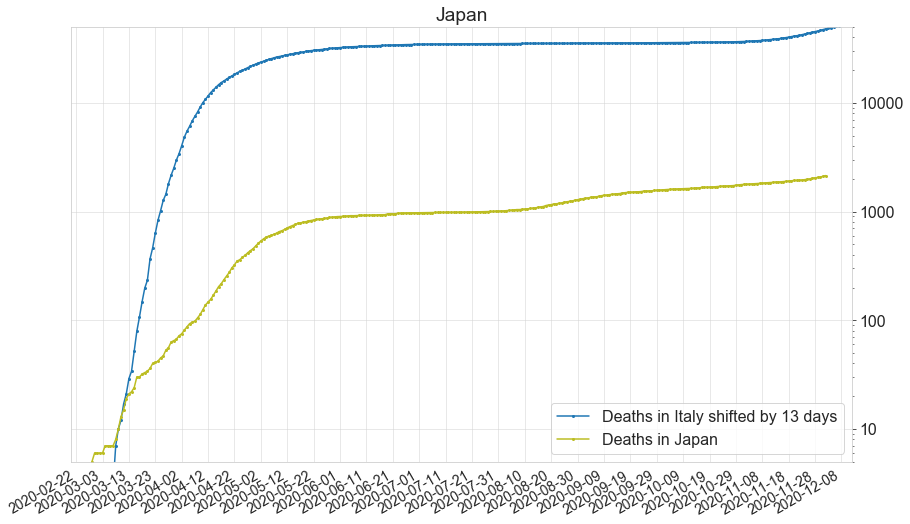

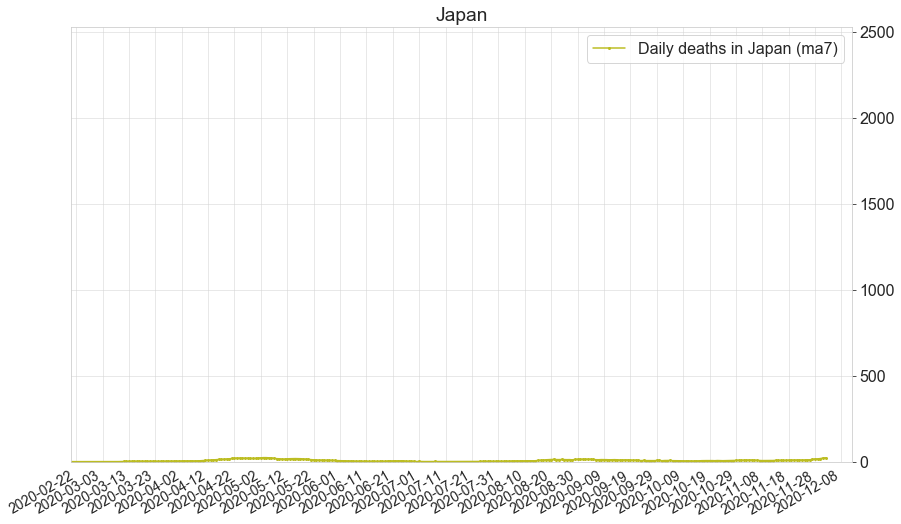

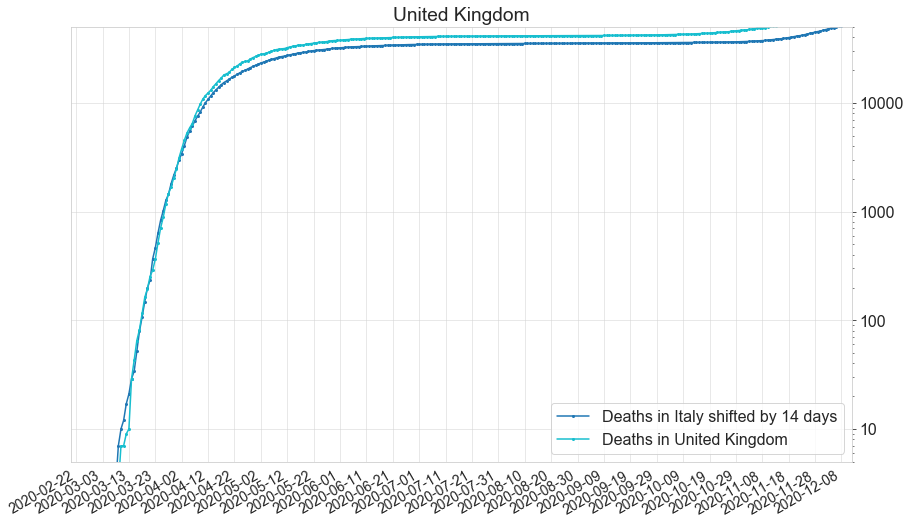

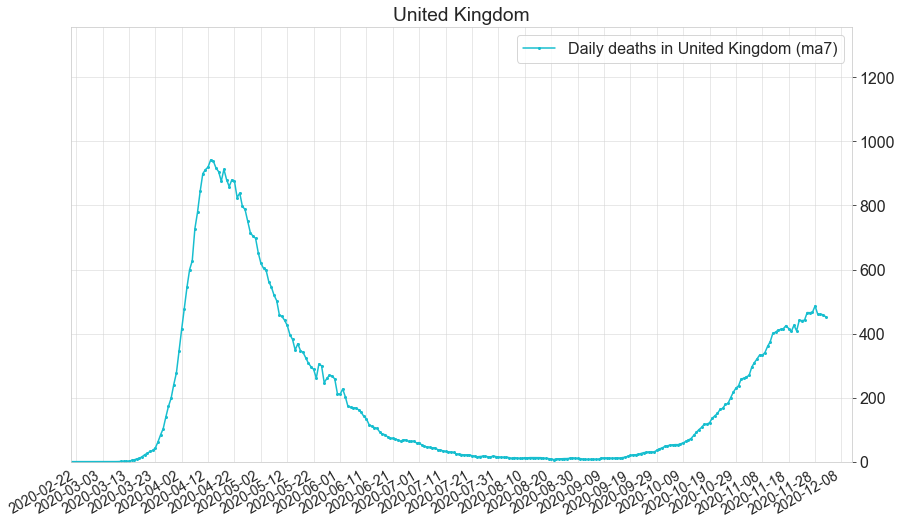

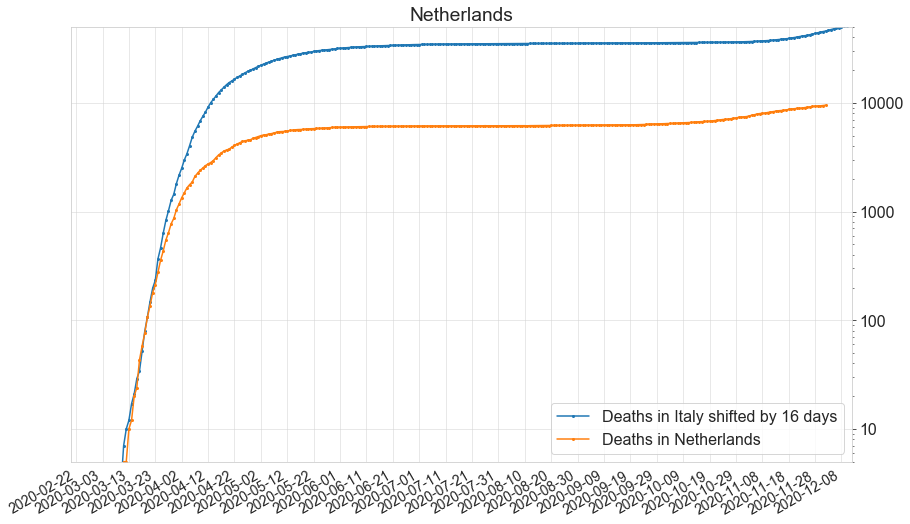

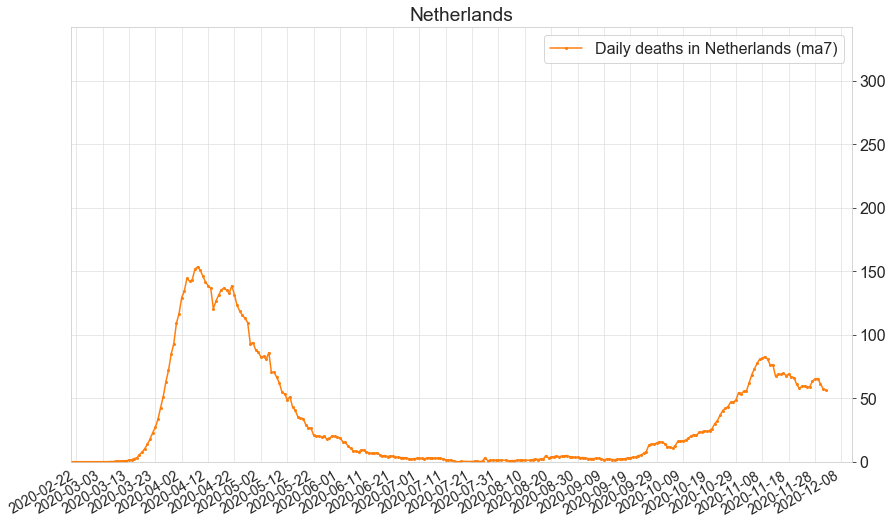

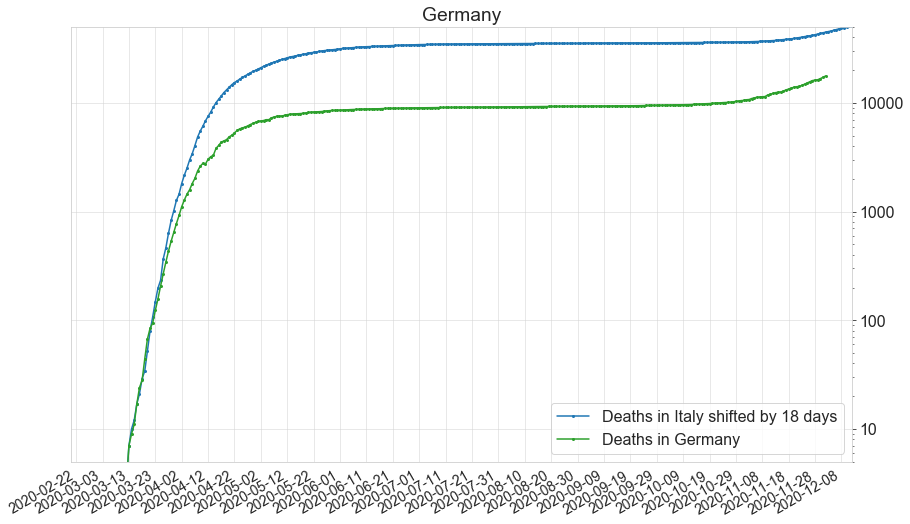

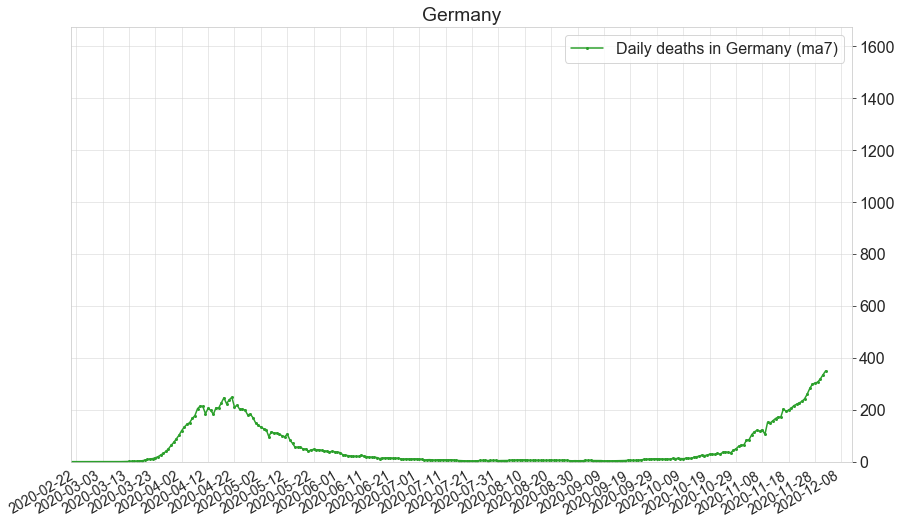

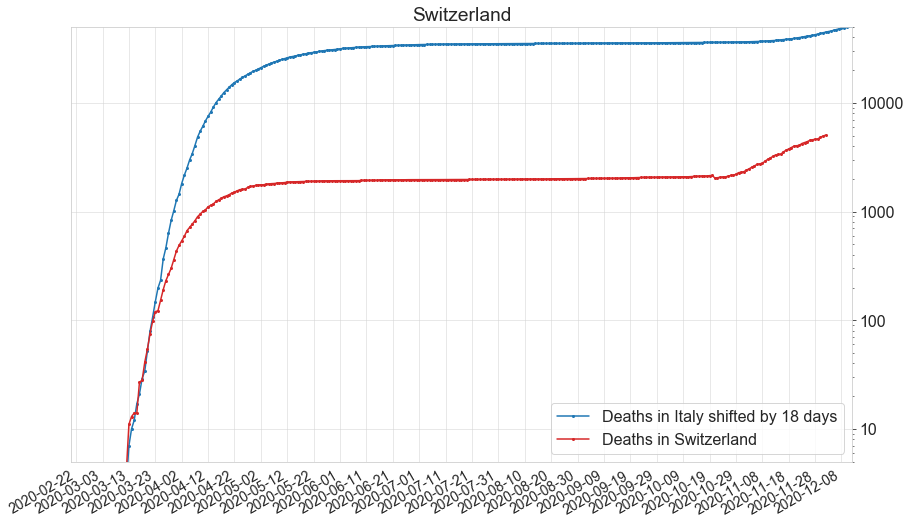

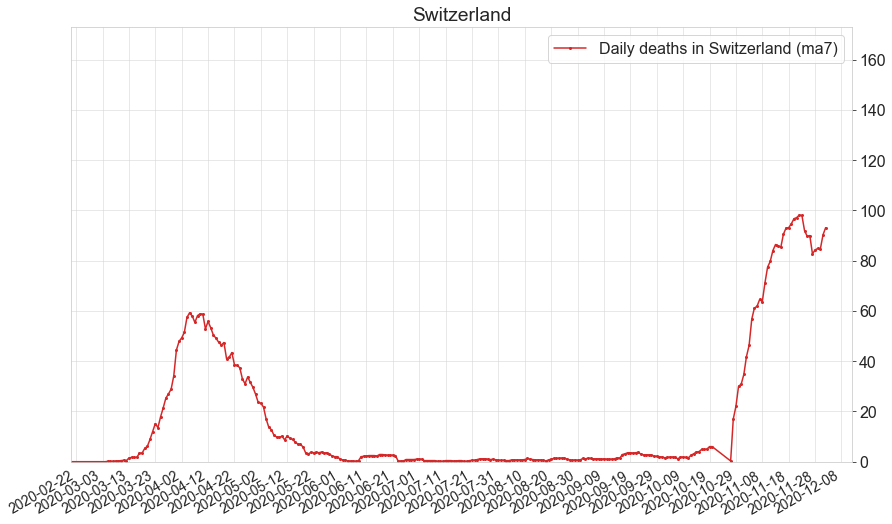

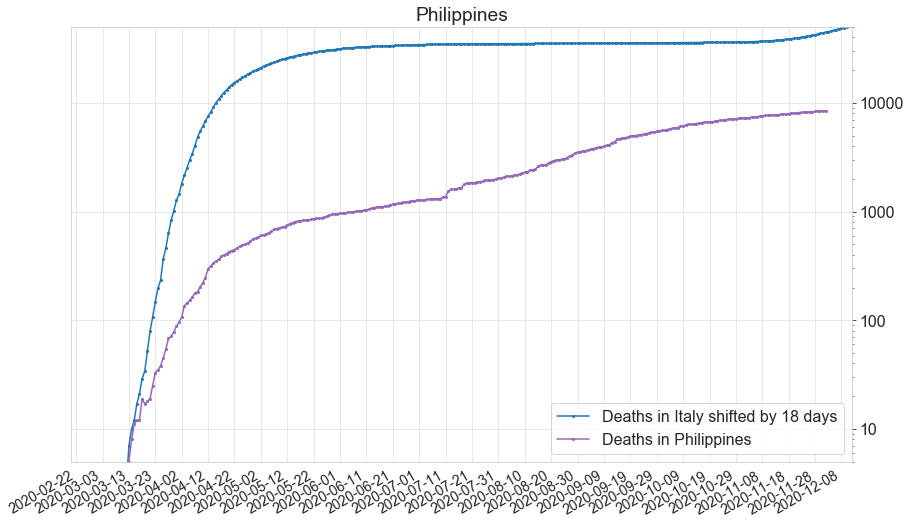

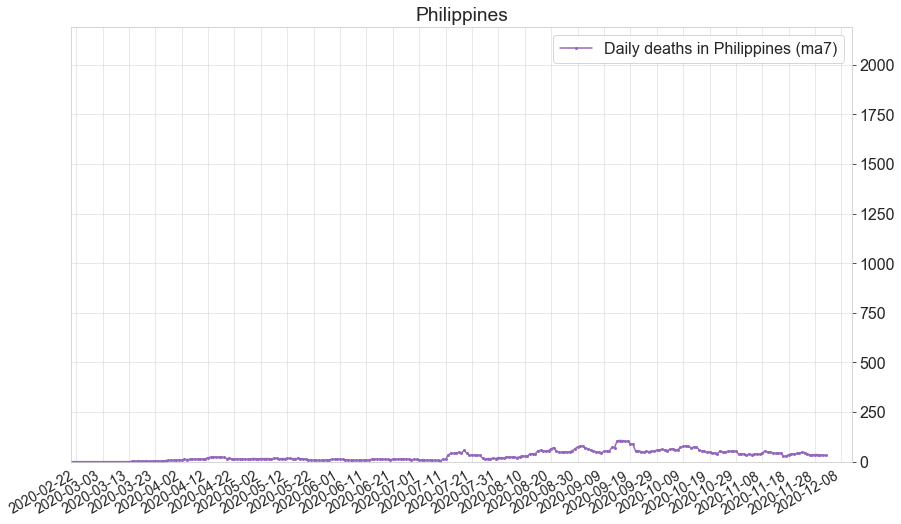

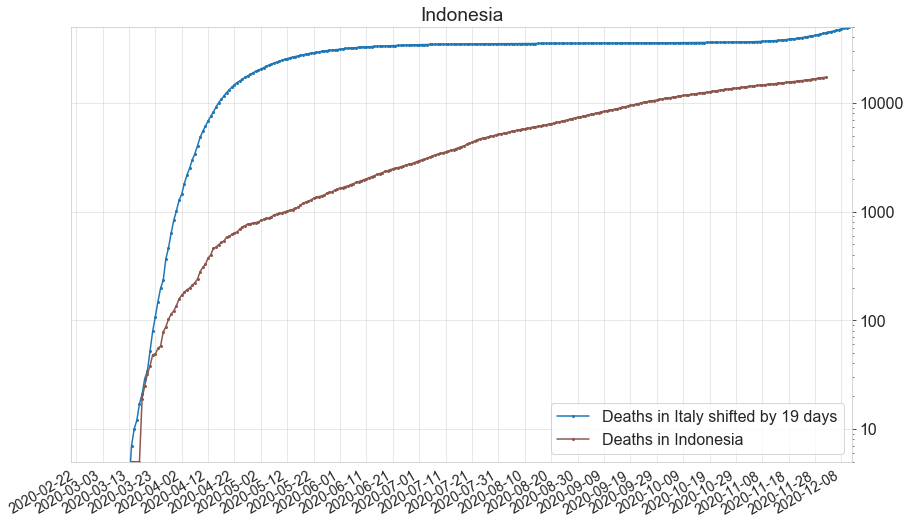

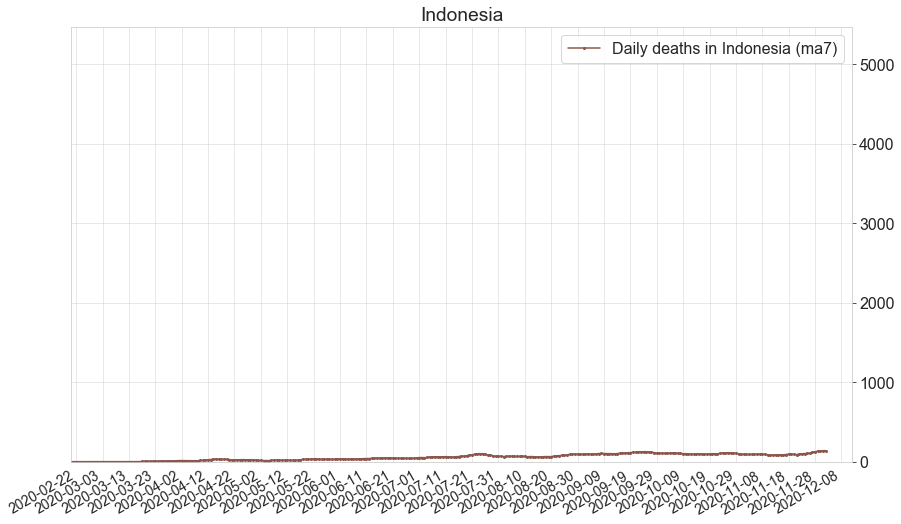

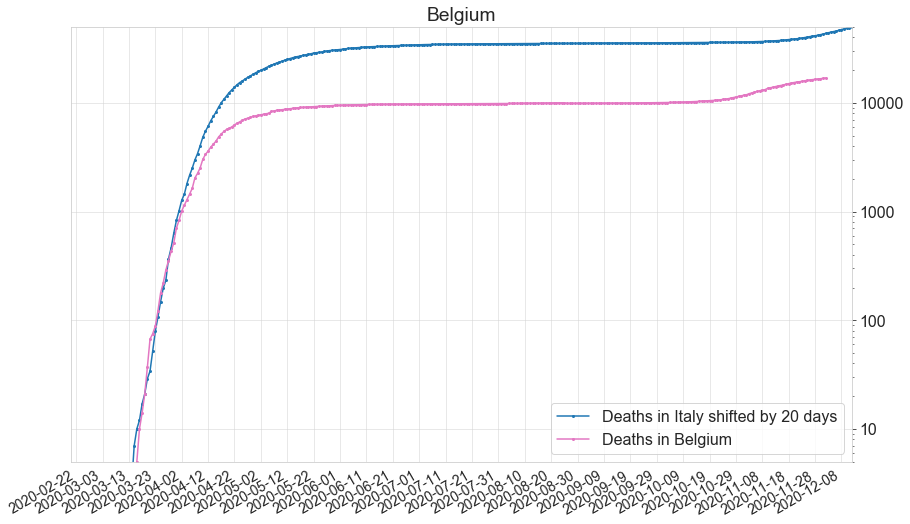

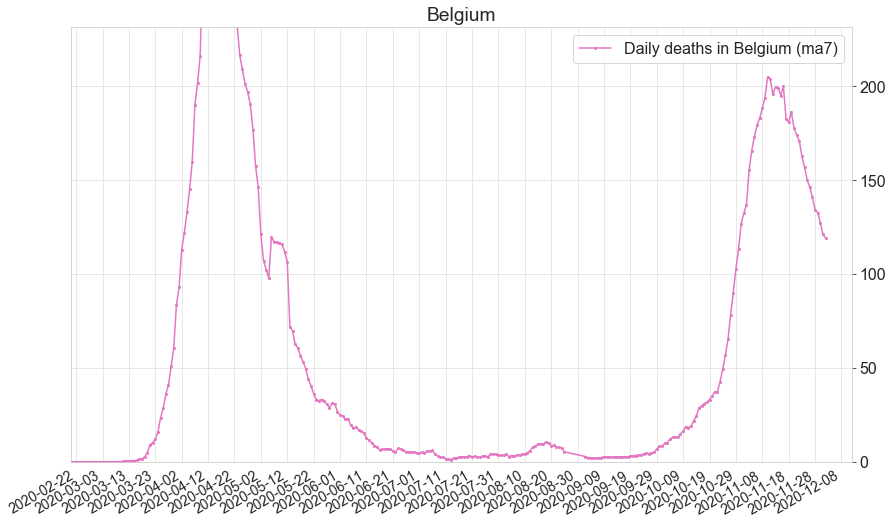

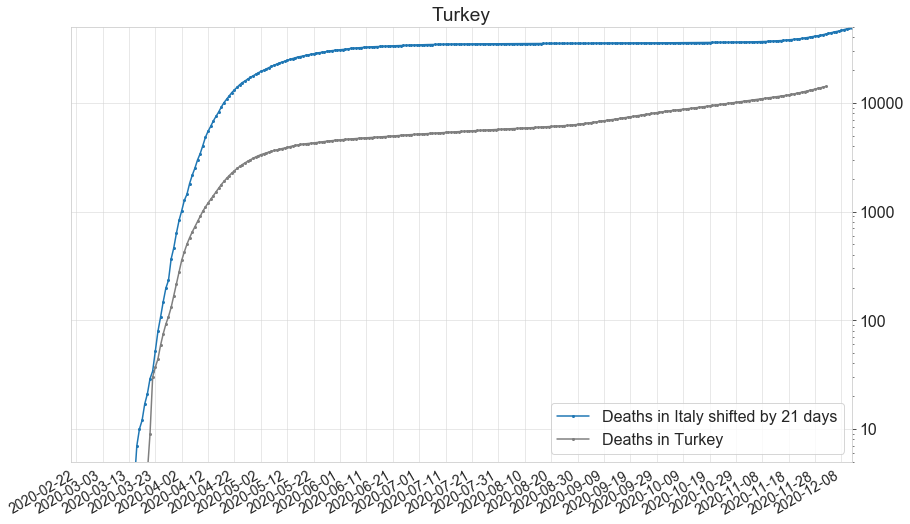

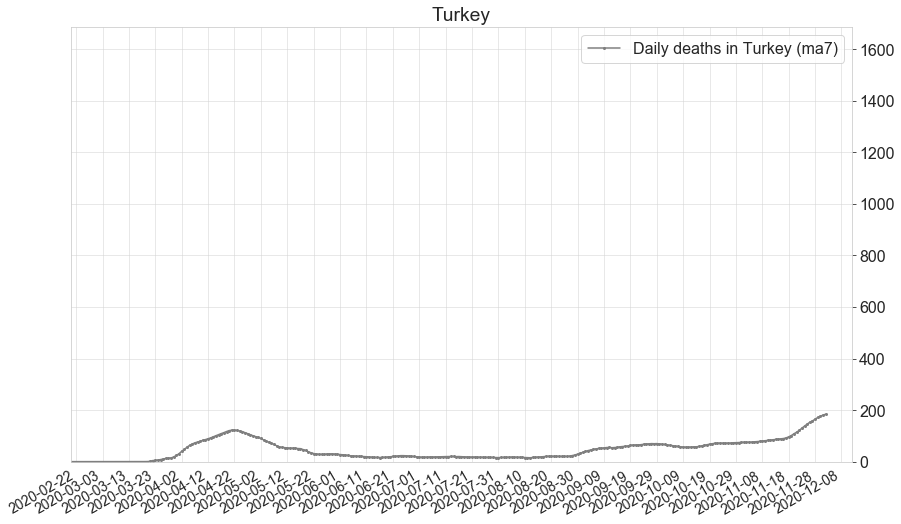

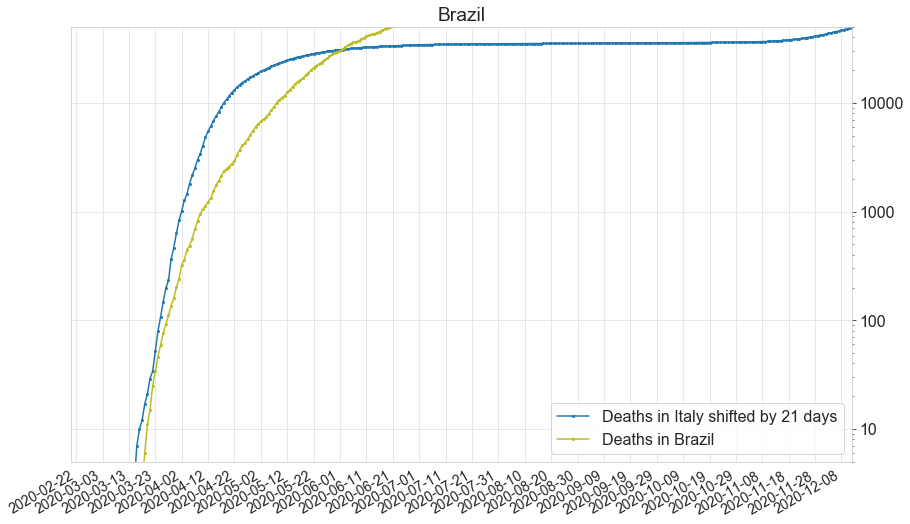

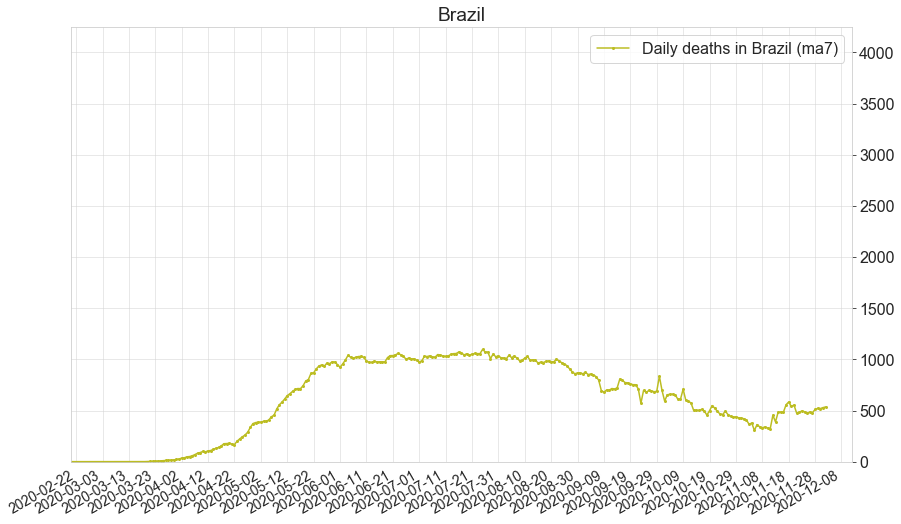

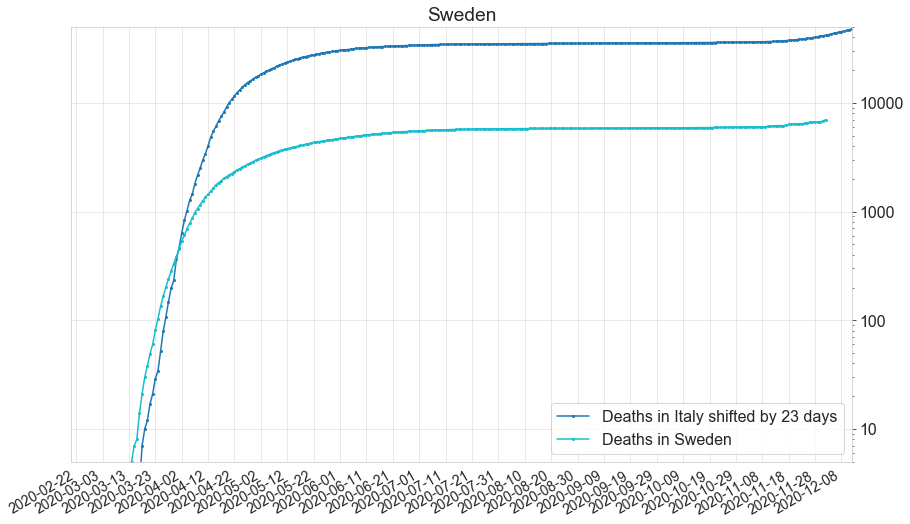

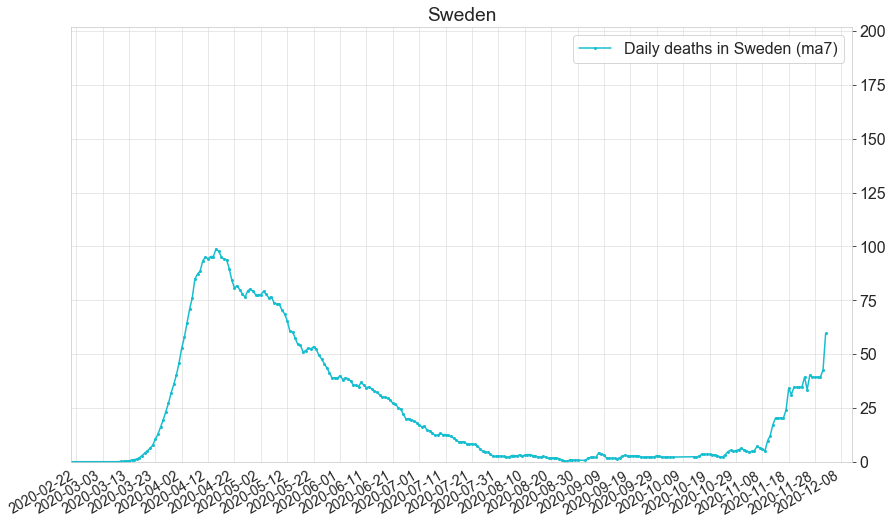

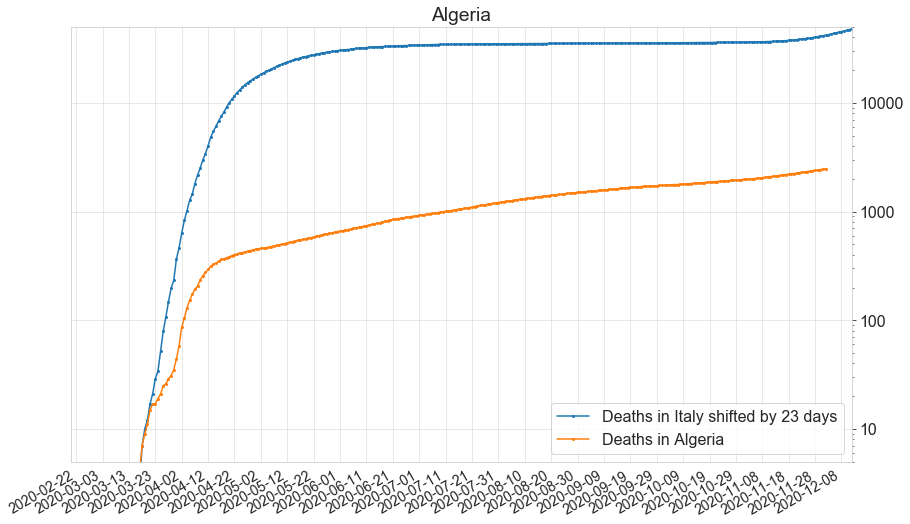

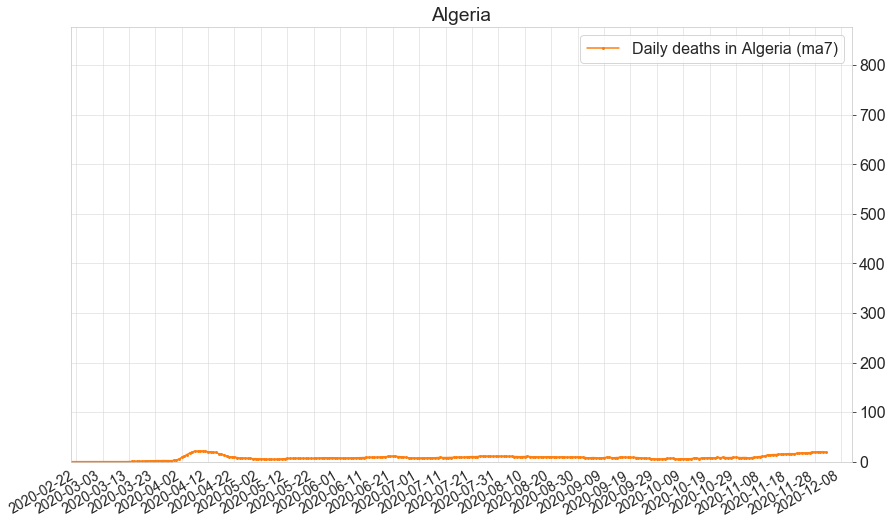

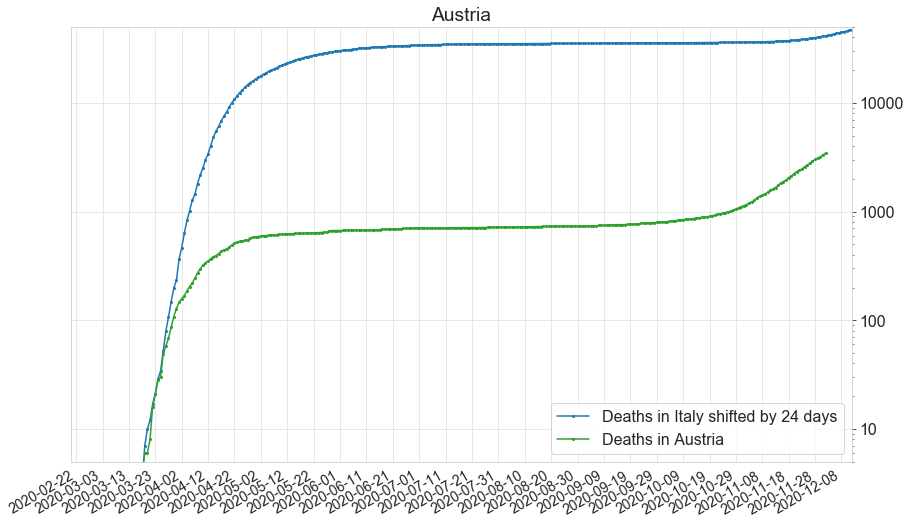

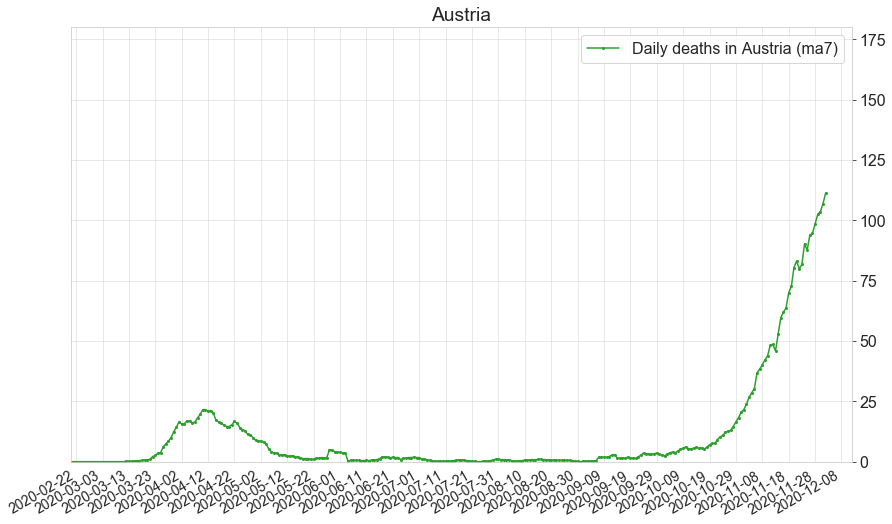

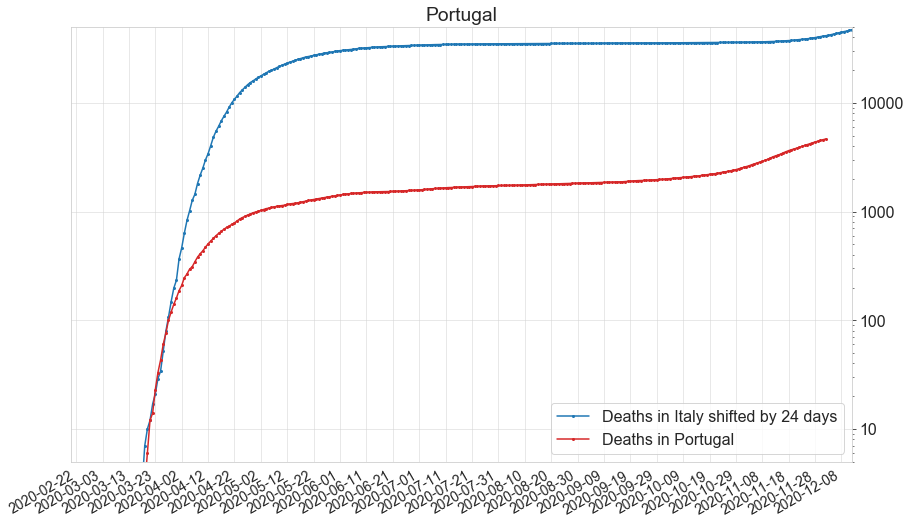

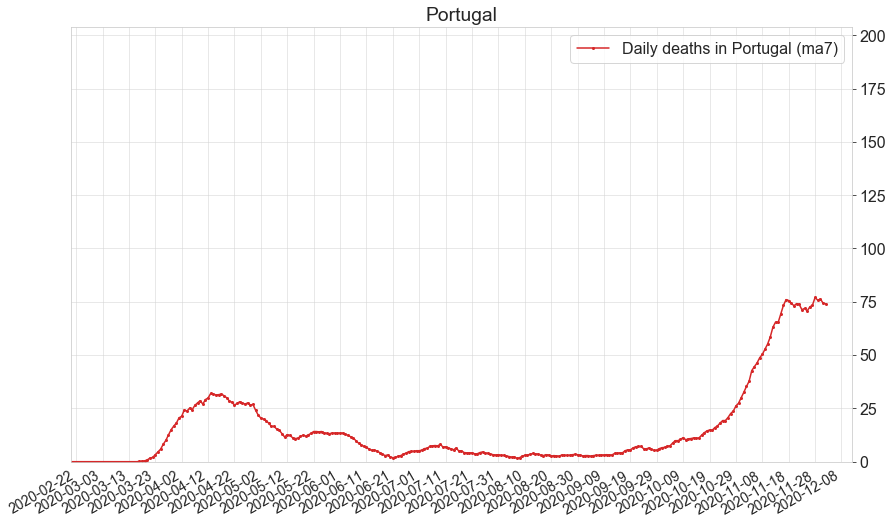

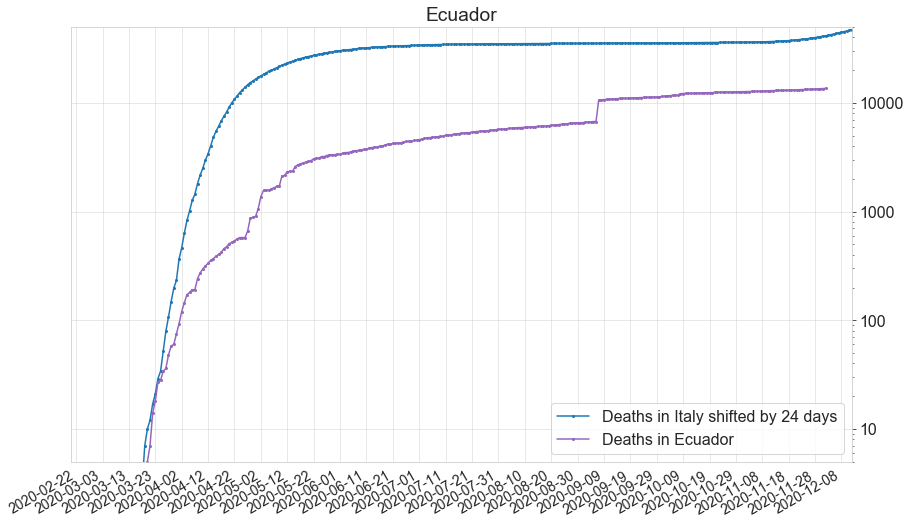

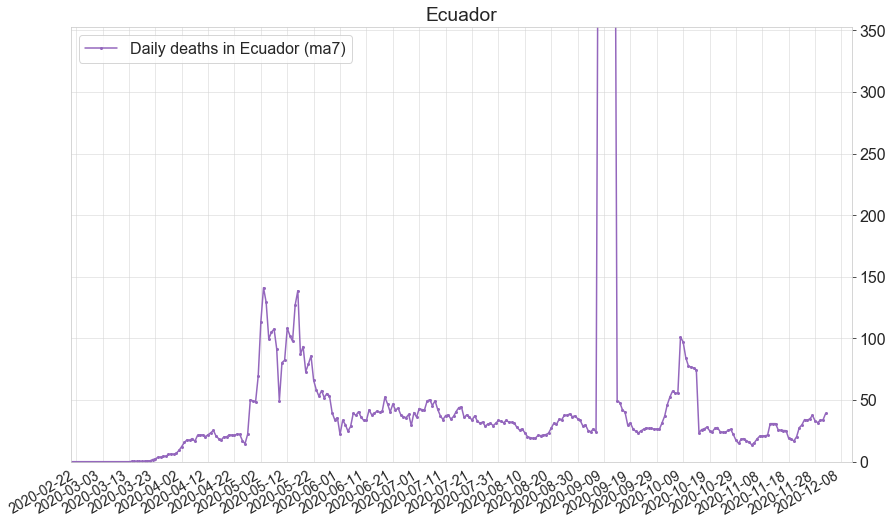

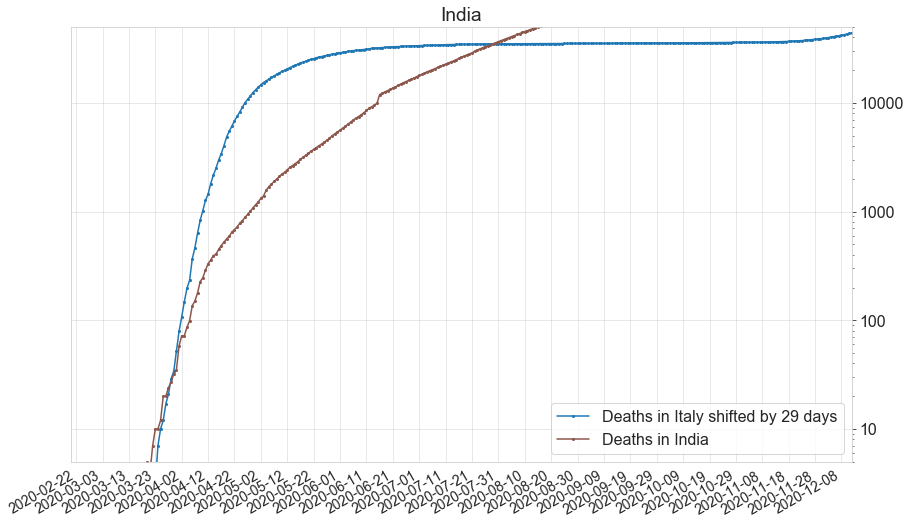

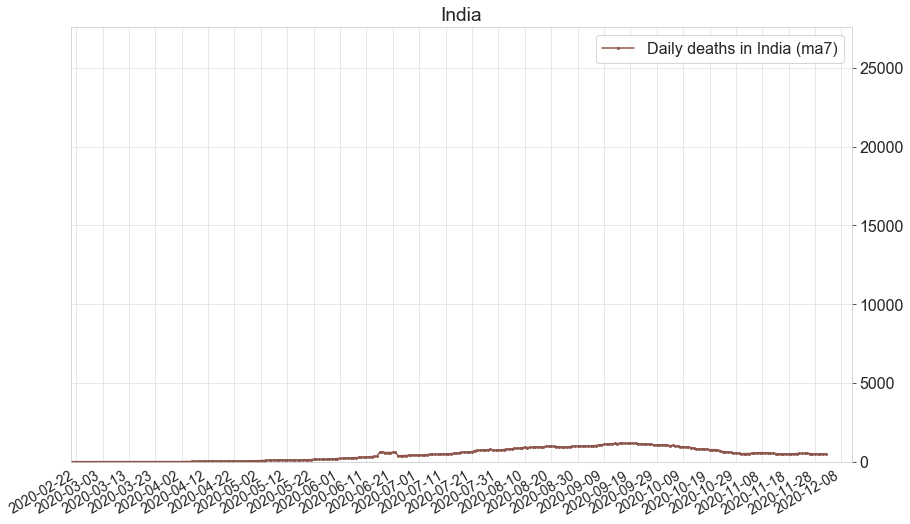

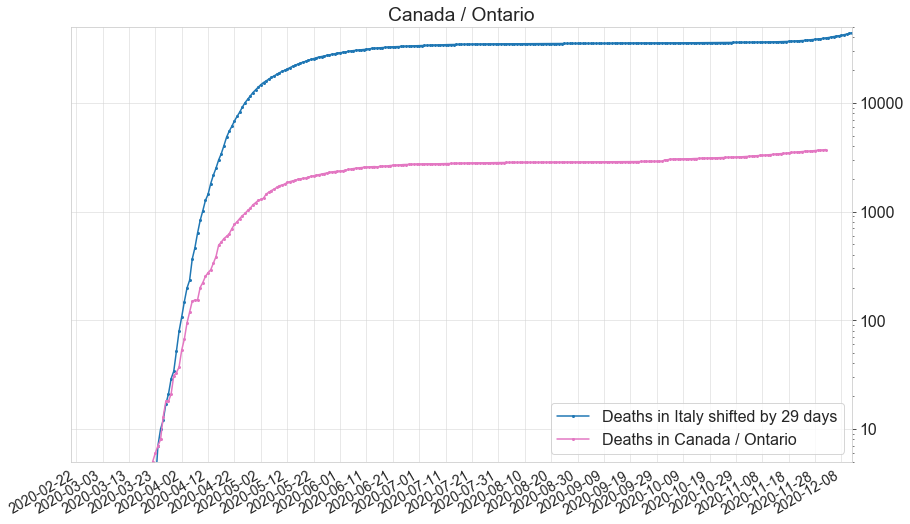

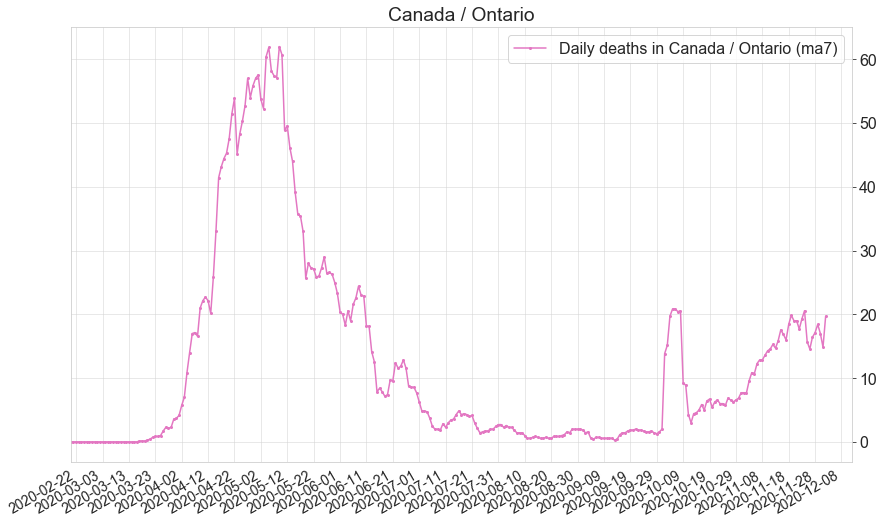

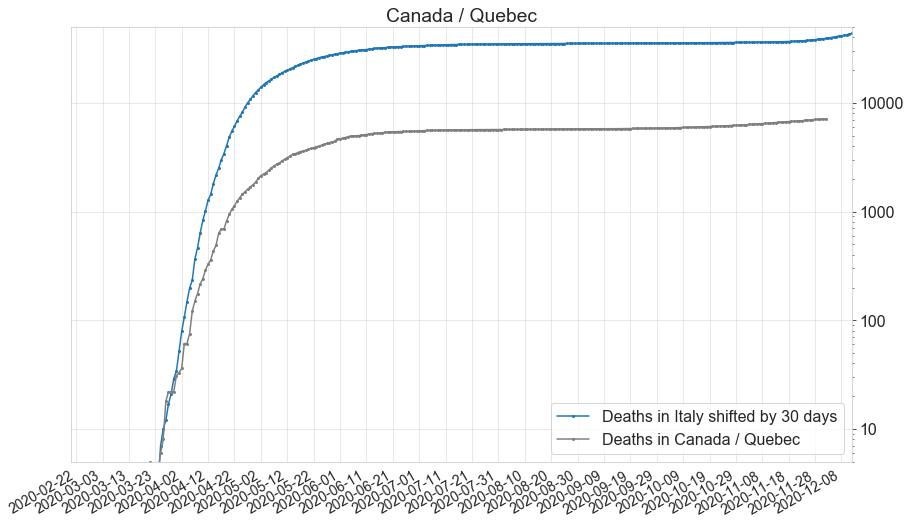

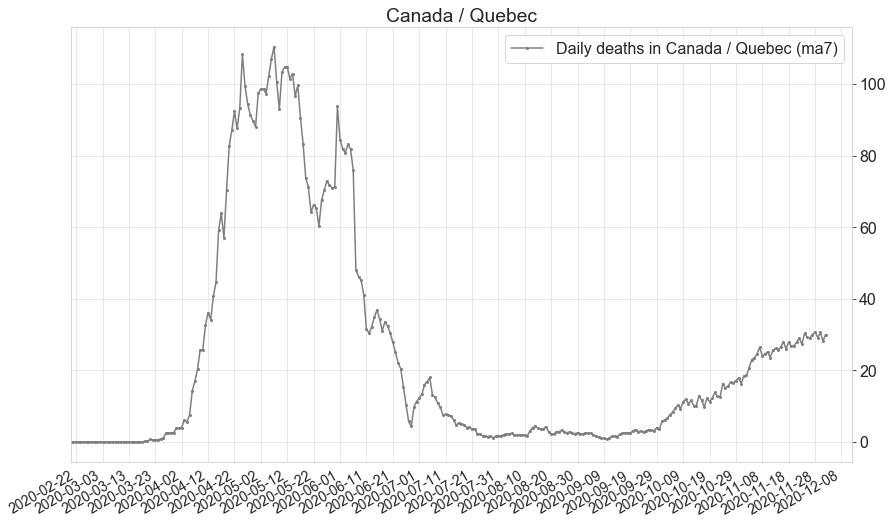

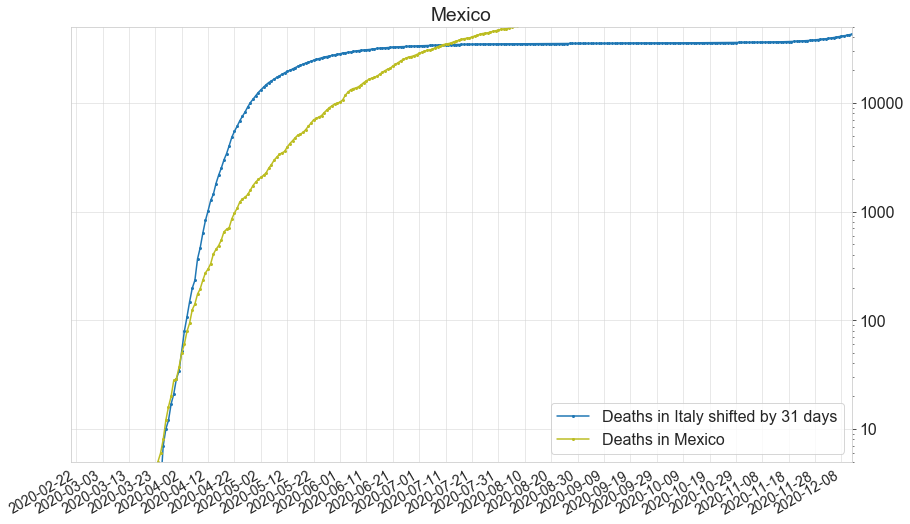

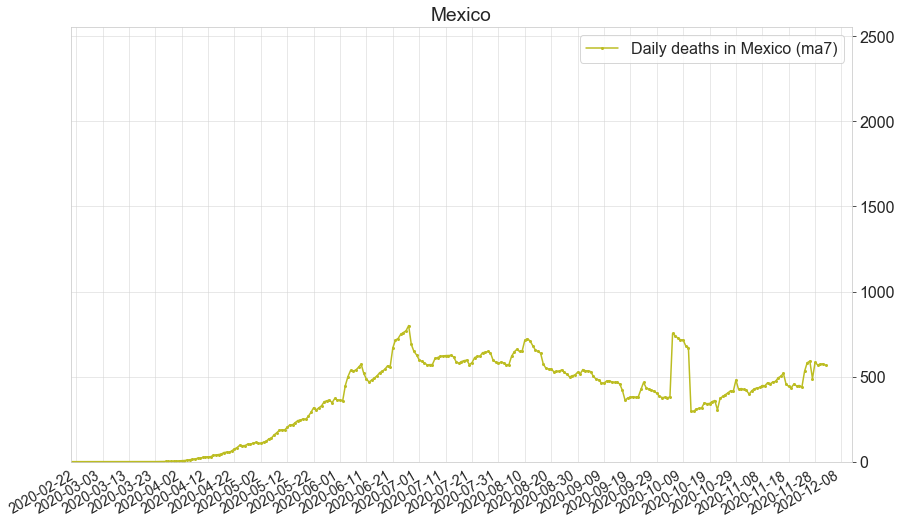

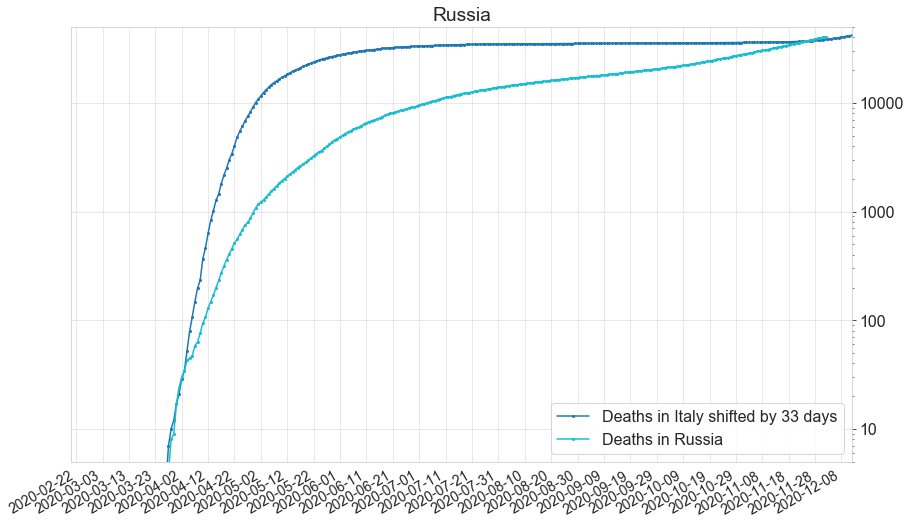

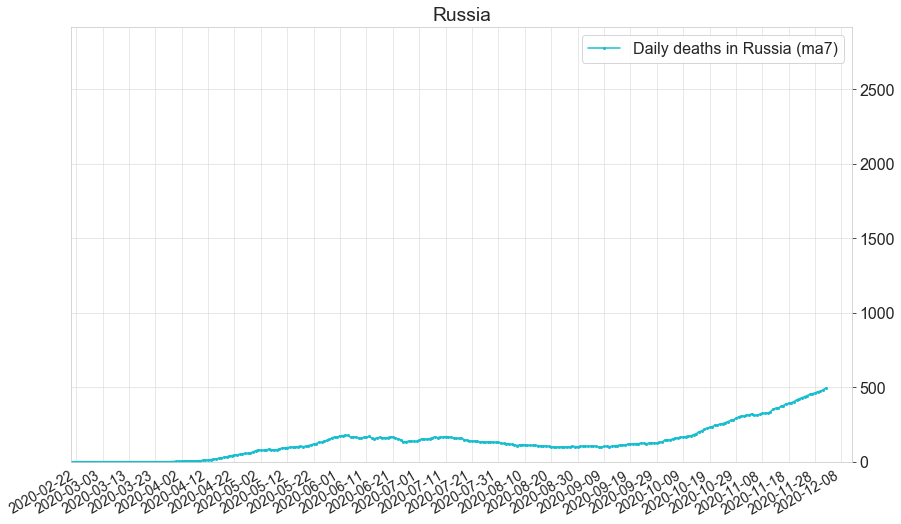

In [51]:
for (country, delay), color in list(zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[1:]))):
    _, ax = covid19.plot.subplots(subplot_kw={
        'yscale': 'log',
        'ylim': (5, 50000),
        # 'ylim': (0, country_data[country]['deaths'].max() * 1.1),
        'xlim': XLIM,
    }, figsize=(14, 8))
    covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths in Italy shifted by {delay} days', delay=delay, color=PALETTE_ONE[0])
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country}', color=color, date_interval=10)
    ax.set_title(f'{country}')
    ax.set(xlabel='', ylabel='')
    ax.legend()

    _, ax = covid19.plot.subplots(subplot_kw={
        # 'ylim': (1, 10000),
        # 'ylim': (0, country_data[country]['deaths'].max() * 1.1),
        'xlim': XLIM
    }, figsize=(14, 8))
    # covid19.plot.plot_data(ax, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True, min_periods=1).mean(), label=f'Daily deaths in Italy shifted by {delay} days', delay=delay, color=PALETTE_ONE[0])
    covid19.plot.plot_data(ax, world.sel(location=country)['daily_deaths7'], label=f'Daily deaths in {country} (ma7)', color=color, date_interval=10)
    ax.set_title(f'{country}')
    ax.set(xlabel='', ylabel='')
    ax.legend()
    try:
        ax.set(ylim=(0, world.sel(location=country).population.values / 50_000))
    except ValueError:
        pass